# Funciones  Implementadas

### Matriz Ingeniería del menu

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from shap.utils.image import display_grid_plot


class MenuEngineeringAnalyzer:
    """
    Ingeniería del Menú (clásica) como objeto:
    - fit(): calcula métricas, umbrales y cuadrantes
    - table(): tabla ejecutiva (limpia) + debug opcional
    - summary_by_quadrant(): resumen por cuadrante (gerencia)
    - plot(): matriz bonita, con opción de tamaño de burbuja por cm_total (unidades*margen)
    """

    def __init__(
        self,
        *,
        # columnas
        col_nombre="item_nombre",
        col_margen="margen",
        col_units=None,            # recomendado (para cm_total y shares)
        col_freq=None,             # si ya tienes "frecuencia" por item; si no, se calcula con unidades
        col_categoria=None,        # opcional
        col_cluster=None,          # opcional para colorear

        # defaults CLÁSICOS
        popularity_factor=0.70,          # x_cut = (1/N)*0.70
        popularity_threshold=None,
        margin_method="mean",            # corte Y clásico: media simple (si margin_threshold es None)
        margin_threshold=None,           # si lo defines, corte fijo de margen (regla de negocio)

        # etiquetas cuadrantes (HH, HL, LH, LL)
        quadrant_labels=("ESTRELLA", "POPULARES", "AMBR", "BMR"),
    ):
        self.col_nombre = col_nombre
        self.col_margen = col_margen
        self.col_units = col_units
        self.col_freq = col_freq
        self.col_categoria = col_categoria
        self.col_cluster = col_cluster

        self.popularity_factor = float(popularity_factor)
        self.popularity_threshold = popularity_threshold
        self.margin_method = margin_method
        self.margin_threshold = margin_threshold
        self.quadrant_labels = quadrant_labels

        # outputs
        self.df_ = None
        self.df_raw_ = None
        self.category_value_ = None
        self.N_ = None
        self.x_cut_ = None
        self.y_cut_ = None
        self.margin_cut_type_ = None

    def fit(self, df: pd.DataFrame, category_value=None):
        d = df.copy()
        self.df_raw_ = df.copy()
        self.category_value_ = category_value

        # filtrar categoría si corresponde
        if self.col_categoria and self.col_categoria in d.columns and category_value is not None:
            d = d[d[self.col_categoria] == category_value].copy()

        if d.empty:
            raise ValueError("No hay datos luego del filtro de categoría / dataset vacío.")

        # validar columnas mínimas
        for c in [self.col_nombre, self.col_margen]:
            if c not in d.columns:
                raise ValueError(f"Falta la columna requerida: {c}")

        # limpieza margen
        d = d.dropna(subset=[self.col_nombre, self.col_margen]).copy()
        d[self.col_margen] = pd.to_numeric(d[self.col_margen], errors="coerce")
        d = d.dropna(subset=[self.col_margen]).copy()
        if d.empty:
            raise ValueError("No hay datos válidos después de limpiar margen.")

        # preparar units/freq si existen
        has_units = self.col_units is not None and self.col_units in d.columns
        has_freq  = self.col_freq is not None and self.col_freq in d.columns

        if has_units:
            d[self.col_units] = pd.to_numeric(d[self.col_units], errors="coerce")
            d = d.dropna(subset=[self.col_units]).copy()

        if has_freq:
            d[self.col_freq] = pd.to_numeric(d[self.col_freq], errors="coerce")
            d = d.dropna(subset=[self.col_freq]).copy()

        if d.empty:
            raise ValueError("No hay datos válidos después de limpiar units/freq.")

        # --- agrupar por plato (y mantener cluster/categoría si existen) ---
        group_cols = [self.col_nombre]
        agg = {self.col_margen: (self.col_margen, "mean")}

        if has_units:
            agg[self.col_units] = (self.col_units, "sum")

        if has_freq:
            # si col_freq viene por ítem o por fila, acá lo consolidamos a nivel ítem
            agg[self.col_freq] = (self.col_freq, "sum")

        if self.col_cluster and self.col_cluster in d.columns:
            agg[self.col_cluster] = (self.col_cluster, "first")
        if self.col_categoria and self.col_categoria in d.columns:
            agg[self.col_categoria] = (self.col_categoria, "first")

        d = d.groupby(group_cols, as_index=False).agg(**agg)

        # --- calcular MIX (popularidad) ---
        # prioridad: unidades -> si no hay unidades, usar col_freq y normalizar
        if has_units and self.col_units in d.columns:
            total_units = float(d[self.col_units].sum())
            if total_units <= 0:
                raise ValueError("Suma de unidades es 0 o negativa.")
            d["mix"] = d[self.col_units] / total_units
        else:
            if not (has_freq and self.col_freq in d.columns):
                raise ValueError("Necesito col_units o col_freq para calcular popularidad (mix).")
            total_f = float(d[self.col_freq].sum())
            if total_f <= 0:
                raise ValueError("Suma de col_freq es 0 o negativa.")
            d["mix"] = d[self.col_freq] / total_f

        # --- umbrales ---
        self.N_ = len(d)
        self.x_cut_ = (
            float(self.popularity_threshold)
            if self.popularity_threshold is not None
            else (1.0 / self.N_) * self.popularity_factor
        )

        if self.margin_threshold is not None:
            self.y_cut_ = float(self.margin_threshold)
            self.margin_cut_type_ = f"fijo={self.y_cut_:.2f}"
        else:
            if self.margin_method == "mean":
                self.y_cut_ = float(d[self.col_margen].mean())
                self.margin_cut_type_ = "media"
            elif self.margin_method == "median":
                self.y_cut_ = float(d[self.col_margen].median())
                self.margin_cut_type_ = "mediana"
            else:
                raise ValueError("margin_method debe ser 'mean' o 'median'.")

        # --- flags y cuadrantes (se mantienen para debug) ---
        d["high_pop"] = d["mix"] >= self.x_cut_
        d["high_mar"] = d[self.col_margen] >= self.y_cut_

        HH, HL, LH, LL = self.quadrant_labels  # (AltaPop&AltaMar, AltaPop&BajaMar, BajaPop&AltaMar, BajaPop&BajaMar)

        def quad_label(hp, hm):
            if hp and hm:  return HH
            if hp and (not hm): return HL
            if (not hp) and hm: return LH
            return LL

        d["cuadrante"] = [quad_label(hp, hm) for hp, hm in zip(d["high_pop"], d["high_mar"])]

        # --- contribución (si hay unidades) ---
        if has_units and self.col_units in d.columns:
            d["cm_total"] = d[self.col_units] * d[self.col_margen]
            total_cm = float(d["cm_total"].sum())
            d["cm_share"] = d["cm_total"] / total_cm if total_cm != 0 else np.nan

        # --- rankings ---
        if has_units and self.col_units in d.columns:
            d["rank_units"] = d[self.col_units].rank(ascending=False, method="dense")
        else:
            d["rank_units"] = np.nan

        d["rank_margin"] = d[self.col_margen].rank(ascending=False, method="dense")

        if "cm_total" in d.columns:
            d["rank_cm_total"] = d["cm_total"].rank(ascending=False, method="dense")

        self.df_ = d.sort_values(["cuadrante", self.col_margen], ascending=[True, False]).reset_index(drop=True)
        return self

    def table(
        self,
        *,
        include_cluster: bool = True,
        sort_by: str = "cm_total",
        ascending: bool = False,
        debug: bool = False,   # si True: high_pop/high_mar
    ):
        """
        Tabla ejecutiva por defecto (limpia):
        - item, categoria (si existe), cluster (si existe y include_cluster=True)
        - cuadrante, mix, margen, unidades, cm_total, cm_share
        - ranks
        debug=True añade high_pop/high_mar.
        """
        if self.df_ is None:
            raise ValueError("Primero ejecuta .fit(df, ...).")

        d = self.df_.copy()
        has_units = self.col_units and self.col_units in d.columns

        cols = [self.col_nombre]

        if self.col_categoria and self.col_categoria in d.columns:
            cols.append(self.col_categoria)

        if include_cluster and self.col_cluster and self.col_cluster in d.columns:
            cols.append(self.col_cluster)

        cols += ["cuadrante", "mix", self.col_margen]

        if has_units:
            cols += [self.col_units, "cm_total", "cm_share", "rank_units", "rank_cm_total"]

        cols += ["rank_margin"]

        if debug:
            cols += ["high_pop", "high_mar"]

        cols = [c for c in cols if c in d.columns]
        out = d[cols].copy()

        # sort fallback
        if sort_by not in out.columns:
            if has_units and "cm_total" in out.columns:
                sort_by = "cm_total"
            elif "mix" in out.columns:
                sort_by = "mix"
            else:
                sort_by = self.col_margen

        out = out.sort_values(sort_by, ascending=ascending).reset_index(drop=True)
        return out

    def summary_by_quadrant(self):
        """
        Resumen por cuadrante:
        - n_items
        - mix_total (suma de mix del cuadrante; suma 1 entre cuadrantes)
        - margen_promedio
        - unidades_totales y units_share (si hay unidades)
        - cm_total y cm_share (si hay unidades)
        """
        if self.df_ is None:
            raise ValueError("Primero ejecuta .fit(df, ...).")

        d = self.df_.copy()
        has_units = self.col_units and self.col_units in d.columns
        has_cm = "cm_total" in d.columns

        agg = {
            "n_items": (self.col_nombre, "count"),
            "mix_total": ("mix", "sum"),
            "margen_promedio": (self.col_margen, "mean"),
        }

        if has_units:
            agg["unidades_totales"] = (self.col_units, "sum")

        if has_cm:
            agg["cm_total"] = ("cm_total", "sum")

        out = d.groupby("cuadrante", as_index=False).agg(**agg)

        if has_units:
            total_u = float(out["unidades_totales"].sum())
            out["units_share"] = out["unidades_totales"] / total_u if total_u else np.nan

        if has_cm:
            total_cm = float(out["cm_total"].sum())
            out["cm_share"] = out["cm_total"] / total_cm if total_cm else np.nan

        # orden estable (HH, HL, LH, LL)
        order = list(self.quadrant_labels)
        out["__ord"] = out["cuadrante"].map({k: i for i, k in enumerate(order)})
        out = out.sort_values("__ord").drop(columns="__ord").reset_index(drop=True)

        return out

    def plot(
            self,
            *,
            point_size=70,

            size_by=None,  # "cm_total" | "cm_share" | None
            size_by_cm_total: bool = False,  # compatibilidad (si True y size_by None => "cm_total")

            size_min: float = 45,
            size_max: float = 220,
            size_transform: str = "rank",  # "rank" | "log1p" | "sqrt" | "none"
            clip_percentiles=(10, 95),

            alpha=0.88,
            show_labels=True,
            label_mode="topk",  # "all" | "topk" | "smart" | "none"
            topk=15,
            smart_min_dist=0.035,
            title_prefix="Matriz de Ingeniería del Menú",
            figsize=(11, 7.5),
            show_quadrant_text=True,
            cluster_palette=None,

        ):
            if self.df_ is None:
                raise ValueError("Primero ejecuta .fit(df, ...).")

            d = self.df_.copy()
            x = d["mix"].values
            y = d[self.col_margen].values
            names = d[self.col_nombre].astype(str).values

            # ---------- tamaños ----------
            def _scale_sizes(v):
                v = np.asarray(v, dtype=float)
                v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
                v = np.maximum(v, 0.0)

                # clip por percentiles (winsor)
                lo, hi = clip_percentiles
                vmin = float(np.percentile(v, lo)) if v.size else 0.0
                vmax = float(np.percentile(v, hi)) if v.size else 1.0
                if vmax > vmin:
                    v = np.clip(v, vmin, vmax)

                # transform
                if size_transform == "rank":
                    r = pd.Series(v).rank(method="average", ascending=True).to_numpy()
                    rmin, rmax = float(np.min(r)), float(np.max(r))
                    if rmax <= rmin:
                        return np.full_like(v, point_size, dtype=float)
                    z = (r - rmin) / (rmax - rmin)

                elif size_transform == "log1p":
                    v2 = np.log1p(v)
                    vmin2, vmax2 = float(np.min(v2)), float(np.max(v2))
                    if vmax2 <= vmin2:
                        return np.full_like(v, point_size, dtype=float)
                    z = (v2 - vmin2) / (vmax2 - vmin2)

                elif size_transform == "sqrt":
                    v2 = np.sqrt(v)
                    vmin2, vmax2 = float(np.min(v2)), float(np.max(v2))
                    if vmax2 <= vmin2:
                        return np.full_like(v, point_size, dtype=float)
                    z = (v2 - vmin2) / (vmax2 - vmin2)

                elif size_transform == "none":
                    vmin2, vmax2 = float(np.min(v)), float(np.max(v))
                    if vmax2 <= vmin2:
                        return np.full_like(v, point_size, dtype=float)
                    z = (v - vmin2) / (vmax2 - vmin2)

                else:
                    raise ValueError("size_transform debe ser 'rank', 'log1p', 'sqrt' o 'none'.")

                return size_min + z * (size_max - size_min)

            # compatibilidad: si no pasan size_by pero sí size_by_cm_total
            if size_by is None and size_by_cm_total:
                size_by = "cm_total"

            sizes = None
            if size_by is not None:
                size_by = str(size_by).lower().strip()

                if size_by == "cm_total":
                    if "cm_total" in d.columns:
                        sizes = _scale_sizes(d["cm_total"].values)
                    elif (self.col_units is not None) and (self.col_units in d.columns):
                        cm = d[self.col_units].values * d[self.col_margen].values
                        sizes = _scale_sizes(cm)
                    else:
                        raise ValueError("No existe cm_total y no hay col_units para construirlo.")

                elif size_by == "cm_share":
                    #  requiere haber calculado cm_total en fit (necesita units)
                    if "cm_share" in d.columns:
                        sizes = _scale_sizes(d["cm_share"].values)
                    else:
                        raise ValueError(
                            "No existe cm_share. Necesitas col_units en fit() para calcular cm_total y cm_share.")

                else:
                    raise ValueError("size_by debe ser None, 'cm_total' o 'cm_share'.")

            # ----------------------------

            fig, ax = plt.subplots(figsize=figsize)

            # color: por cluster si existe; si no, por cuadrante
            if self.col_cluster and self.col_cluster in d.columns:
                # valores de cluster tal cual (pueden ser 0,1,2 o texto)
                clusters = d[self.col_cluster].values
                unique = np.sort(pd.unique(clusters))

                # --- mapa cluster → color ---
                if cluster_palette is not None:
                    # cluster_palette puede ser dict {label: color}
                    # o lista en el orden de los clusters únicos
                    color_map = {}

                    if isinstance(cluster_palette, dict):
                        for i, c in enumerate(unique):
                            # busca primero por clave exacta, luego por str(c)
                            color_map[c] = (
                                cluster_palette.get(c,
                                                    cluster_palette.get(str(c), plt.cm.tab10(i % 10)))
                            )
                    else:
                        # asumimos lista/tupla en el mismo orden de "unique"
                        for i, c in enumerate(unique):
                            if i < len(cluster_palette):
                                color_map[c] = cluster_palette[i]
                            else:
                                color_map[c] = plt.cm.tab10(i % 10)
                else:
                    # si no se pasa nada, usamos tab10 por defecto
                    cmap = plt.cm.get_cmap("tab10", max(1, len(unique)))
                    color_map = {c: cmap(i) for i, c in enumerate(unique)}

                # colores para cada punto
                point_colors = [color_map[c] for c in clusters]

                ax.scatter(
                    x, y,
                    s=(sizes if sizes is not None else point_size),
                    c=point_colors,
                    alpha=alpha,
                    edgecolors="black",
                    linewidths=0.6
                )

                def point_color(i):
                    return color_map[clusters[i]]

                # leyenda
                handles = []
                for c in unique:
                    handles.append(
                        plt.Line2D(
                            [], [], marker="o", linestyle="",
                            markersize=8,
                            markerfacecolor=color_map[c],
                            markeredgecolor="black",
                            label=str(c),
                        )
                    )
                ax.legend(handles=handles, title="Clusters",
                          fontsize=9, title_fontsize=10, loc="best")
            else:
                q = d["cuadrante"].values
                HH, HL, LH, LL = self.quadrant_labels
                palette = {HH: "tab:green", HL: "tab:orange", LH: "tab:purple", LL: "tab:red"}
                colors = [palette.get(qq, "tab:blue") for qq in q]

                ax.scatter(
                    x, y,
                    s=(sizes if sizes is not None else point_size),
                    c=colors,
                    alpha=alpha,
                    edgecolors="black",
                    linewidths=0.6
                )

                def point_color(i):
                    return colors[i]

            # cortes
            ax.axvline(self.x_cut_, color="darkorange", linestyle="--", linewidth=2.2)
            ax.axhline(self.y_cut_, color="darkorange", linestyle="--", linewidth=2.2)

            # texto cuadrantes
            if show_quadrant_text:
                HH, HL, LH, LL = self.quadrant_labels
                xmin, xmax = float(x.min()), float(x.max())
                ymin, ymax = float(y.min()), float(y.max())
                ax.text((self.x_cut_ + xmax) / 2, (self.y_cut_ + ymax) / 2, HH,
                        ha="center", va="center", alpha=0.18, fontsize=16)
                ax.text((self.x_cut_ + xmax) / 2, (ymin + self.y_cut_) / 2, HL,
                        ha="center", va="center", alpha=0.18, fontsize=16)
                ax.text((xmin + self.x_cut_) / 2, (self.y_cut_ + ymax) / 2, LH,
                        ha="center", va="center", alpha=0.18, fontsize=16)
                ax.text((xmin + self.x_cut_) / 2, (ymin + self.y_cut_) / 2, LL,
                        ha="center", va="center", alpha=0.18, fontsize=16)

            # etiquetas
            if show_labels and label_mode != "none":
                N = len(d)
                if label_mode == "all":
                    idxs = range(N)
                elif label_mode == "topk":
                    if self.col_units and self.col_units in d.columns:
                        idxs = d[self.col_units].sort_values(ascending=False).head(topk).index.tolist()
                    else:
                        idxs = pd.Series(x).sort_values(ascending=False).head(topk).index.tolist()
                elif label_mode == "smart":
                    xr = (x.max() - x.min()) or 1.0
                    yr = (y.max() - y.min()) or 1.0
                    dist_v = np.abs(x - self.x_cut_) / xr
                    dist_h = np.abs(y - self.y_cut_) / yr
                    idxs = np.where((dist_v >= smart_min_dist) & (dist_h >= smart_min_dist))[0]
                else:
                    raise ValueError("label_mode inválido.")

                for i in idxs:
                    ax.annotate(
                        names[i], (x[i], y[i]),
                        xytext=(5, 5), textcoords="offset points",
                        fontsize=8, fontweight="bold",
                        color=point_color(i),
                        path_effects=[pe.withStroke(linewidth=3, foreground="white")]
                    )

            # título
            cat = self.category_value_
            head = title_prefix if cat is None else f"{title_prefix} - {cat}"
            y_label = self.margin_cut_type_ if self.margin_cut_type_ else self.margin_method

            size_info = ""
            if size_by is not None:
                size_info = f" | size={size_by}({size_transform}, p{clip_percentiles[0]}–p{clip_percentiles[1]})"

            sub = (
                f"N={self.N_} | x_corte=(1/N)*{self.popularity_factor:.2f} => {self.x_cut_:.4f} | "
                f"y_corte({y_label}) => {self.y_cut_:.2f}{size_info}"
            )

            ax.set_title(f"{head}\n{sub}", fontsize=13, fontweight="bold", pad=14)
            ax.set_xlabel("Frecuencia de venta (Mix)", fontsize=12)
            ax.set_ylabel("Margen unitario (S/)", fontsize=12)
            ax.grid(True, linestyle="--", alpha=0.22)
            ax.set_axisbelow(True)

            plt.tight_layout()
            plt.show()
            return fig, ax


### Clustering Herárquico con cortes dinámicos


In [278]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # <-- FIX para dendrogram colors (#RRGGBB)

from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage as scipy_linkage
from scipy.cluster.hierarchy import dendrogram


ArrayLike = Union[np.ndarray, pd.DataFrame]


@dataclass
class DynamicHACResult:
    labels: np.ndarray
    df_result: pd.DataFrame
    silhouette_summary: pd.DataFrame
    history: pd.DataFrame
    Z: np.ndarray
    active_nodes: List[int]
    fig_dendrogram: Optional[plt.Figure] = None
    fig_scatter: Optional[plt.Figure] = None


def _to_numpy(X: ArrayLike) -> Tuple[np.ndarray, Optional[List[str]]]:
    if isinstance(X, pd.DataFrame):
        return X.to_numpy(), list(X.columns)
    return np.asarray(X), None


def _validate_linkage_metric(linkage: str, metric: str) -> None:
    # Ward requiere métrica euclidiana.
    if linkage == "ward" and metric != "euclidean":
        raise ValueError("linkage='ward' requiere metric='euclidean'.")


def _build_tree_helpers(Z: np.ndarray, n: int):
    """
    En SciPy:
      - hojas: 0..n-1
      - nodos internos: n..2n-2
      - Z tiene shape (n-1, 4); fila i describe el nodo n+i, con hijos Z[i,0], Z[i,1]
    """
    children_cache: Dict[int, Tuple[int, int]] = {}
    leaves_cache: Dict[int, np.ndarray] = {}

    def children(node: int) -> Tuple[int, int]:
        if node < n:
            raise ValueError("Una hoja no tiene hijos.")
        if node in children_cache:
            return children_cache[node]
        row = int(node - n)
        a, b = int(Z[row, 0]), int(Z[row, 1])
        children_cache[node] = (a, b)
        return a, b

    def leaves(node: int) -> np.ndarray:
        if node in leaves_cache:
            return leaves_cache[node]
        if node < n:
            arr = np.array([node], dtype=int)
            leaves_cache[node] = arr
            return arr
        a, b = children(node)
        arr = np.concatenate([leaves(a), leaves(b)])
        leaves_cache[node] = arr
        return arr

    def node_dist(node: int) -> float:
        if node < n:
            return 0.0
        row = int(node - n)
        return float(Z[row, 2])

    return children, leaves, node_dist


def plot_clusters_2d(
    X: ArrayLike,
    labels: np.ndarray,
    method: str = "pca",
    figsize: Tuple[int, int] = (8, 6),
    title: str = "Clusters finales (visualización 2D)",
) -> plt.Figure:
    """
    Scatter 2D SOLO para visualizar (no afecta el clustering).
    method: 'pca' (default)
    """
    X_np, _ = _to_numpy(X)
    X_np = np.asarray(X_np, dtype=float)

    if method.lower() != "pca":
        method = "pca"

    emb = PCA(n_components=2, random_state=0).fit_transform(X_np)

    fig, ax = plt.subplots(figsize=figsize)
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=labels, s=20)
    ax.set_title(title + f" (method={method})")
    ax.set_xlabel("Comp 1")
    ax.set_ylabel("Comp 2")
    ax.grid(True, alpha=0.2)
    plt.colorbar(sc, ax=ax, label="cluster_dyn")
    return fig


def plot_dendrogram_colored_by_labels(
    Z: np.ndarray,
    labels_final: np.ndarray,
    split_nodes: Optional[Iterable[int]] = None,
    figsize: Tuple[int, int] = (14, 6),
    title: str = "Dendrograma + cortes dinámicos",
    linewidth: float = 2.5,
) -> plt.Figure:
    """
    Dendrograma donde cada rama que ya es 'pura' (todas sus hojas pertenecen al mismo cluster final)
    se pinta con el color de ese cluster. Ramas mixtas se quedan en gris.
    Opcional: dibuja líneas horizontales para split_nodes.

    FIX: link_color_func debe retornar un color string (p.ej. '#RRGGBB'), no tuplas RGBA.
    """
    labels_final = np.asarray(labels_final)
    n = Z.shape[0] + 1

    # hijos de cada nodo interno: node_id = n + i
    children = {n + i: (int(Z[i, 0]), int(Z[i, 1])) for i in range(n - 1)}
    node_dist = {n + i: float(Z[i, 2]) for i in range(n - 1)}

    clusters_under: Dict[int, set] = {}
    leaves_cache: Dict[int, np.ndarray] = {}

    def leaves(node: int) -> np.ndarray:
        if node in leaves_cache:
            return leaves_cache[node]
        if node < n:
            arr = np.array([node], dtype=int)
        else:
            a, b = children[node]
            arr = np.concatenate([leaves(a), leaves(b)])
        leaves_cache[node] = arr
        return arr

    def clusters(node: int) -> set:
        if node in clusters_under:
            return clusters_under[node]
        if node < n:
            s = {int(labels_final[node])}
        else:
            a, b = children[node]
            s = clusters(a) | clusters(b)
        clusters_under[node] = s
        return s

    # Paleta y mapa cluster->HEX string
    uniq = np.unique(labels_final)
    cmap = plt.cm.get_cmap("tab20", len(uniq))
    color_map = {int(c): mcolors.to_hex(cmap(i)) for i, c in enumerate(uniq)}

    def link_color_func(node_id: int) -> str:
        s = clusters(int(node_id))
        if len(s) == 1:
            c = int(next(iter(s)))
            return color_map[c]  # '#RRGGBB'
        return "gray"

    fig, ax = plt.subplots(figsize=figsize)
    d = dendrogram(
        Z,
        ax=ax,
        no_labels=True,
        above_threshold_color="gray",
        link_color_func=link_color_func,
    )

    # líneas de cortes dinámicos
    if split_nodes is not None:
        leaf_order = d["leaves"]
        x_pos = {leaf: 5 + 10 * i for i, leaf in enumerate(leaf_order)}

        for node in split_nodes:
            node = int(node)
            idx = leaves(node)
            xs = [x_pos[int(i)] for i in idx]
            ax.hlines(node_dist[node], float(min(xs)), float(max(xs)), linewidth=linewidth)

    ax.set_title(title)
    ax.set_ylabel("Distancia (linkage)")
    ax.set_xlabel("Observaciones (orden dendrograma)")
    ax.grid(True, alpha=0.2)
    return fig


def dynamic_hac_silhouette(
    X: ArrayLike,
    ids: Optional[Union[pd.Series, np.ndarray, List[Any]]] = None,
    min_sil: float = 0.7,
    linkage: str = "ward",
    metric: str = "euclidean",
    max_splits: int = 200,
    min_cluster_size_to_split: int = 2,
    return_features: bool = True,
    make_plots: bool = True,
    plot_method_2d: str = "pca",
    dendro_figsize: Tuple[int, int] = (14, 6),
    scatter_figsize: Tuple[int, int] = (8, 6),
) -> DynamicHACResult:
    """
    Construye el árbol HAC una sola vez (SciPy linkage) y luego hace splits dinámicos
    guiados por silhouette promedio del peor cluster (excluyendo clusters muy chicos).

    Además, si make_plots=True:
      - genera un dendrograma COLOREADO por los clusters FINALES (corte dinámico) y
        dibuja las líneas horizontales de los nodos que fueron partidos.
      - genera un scatter 2D (PCA) de los clusters finales (solo visual).
    """
    X_np, feat_cols = _to_numpy(X)
    X_np = np.asarray(X_np, dtype=float)
    n = X_np.shape[0]

    if n < 2:
        raise ValueError("Se requieren al menos 2 filas para clustering jerárquico.")

    _validate_linkage_metric(linkage, metric)

    # 1) Árbol completo una sola vez
    Z = scipy_linkage(X_np, method=linkage, metric=metric)

    # helpers
    children, leaves, node_dist = _build_tree_helpers(Z, n)
    root = 2 * n - 2  # nodo raíz

    # 2) Estado inicial: 1 cluster (raíz)
    active_nodes: List[int] = [root]

    history_rows: List[Dict[str, Any]] = []
    split_events: List[Dict[str, Any]] = []

    def build_labels(active: List[int]) -> Tuple[np.ndarray, Dict[int, int], Dict[int, int]]:
        labels = np.full(n, -1, dtype=int)
        node_to_label: Dict[int, int] = {}
        label_to_node: Dict[int, int] = {}
        for k, node in enumerate(active):
            idx = leaves(node)
            labels[idx] = k
            node_to_label[node] = k
            label_to_node[k] = node
        return labels, node_to_label, label_to_node

    # Itera abriendo cortes
    for it in range(max_splits):
        labels, _, label_to_node = build_labels(active_nodes)
        k = len(active_nodes)

        # Caso: 1 cluster -> forzar split si se puede
        if k == 1:
            node = active_nodes[0]
            size = len(leaves(node))
            if size < min_cluster_size_to_split:
                history_rows.append(
                    dict(iter=it, n_clusters=k, action="STOP", reason="root_too_small", worst_cluster=0, worst_sil=np.nan)
                )
                break

            a, b = children(node)
            active_nodes = [a, b]
            split_events.append(
                dict(iter=it, split_node=node, split_dist=node_dist(node), left=a, right=b, split_size=size)
            )
            history_rows.append(
                dict(iter=it, n_clusters=1, action="SPLIT", reason="forced_first_split", worst_cluster=0, worst_sil=np.nan)
            )
            continue

        # Silhouette por muestra y por cluster
        sil = silhouette_samples(X_np, labels)
        df_s = pd.DataFrame({"cluster": labels, "sil": sil})
        stats = (
            df_s.groupby("cluster", as_index=False)
            .agg(cantidad=("sil", "size"), silueta_promedio=("sil", "mean"))
        )

        # candidatos a partir
        cand = stats[stats["cantidad"] >= min_cluster_size_to_split].copy()
        if cand.empty:
            history_rows.append(
                dict(iter=it, n_clusters=k, action="STOP", reason="no_splittable_clusters", worst_cluster=None, worst_sil=np.nan)
            )
            break

        worst_row = cand.loc[cand["silueta_promedio"].idxmin()]
        worst_label = int(worst_row["cluster"])
        worst_sil = float(worst_row["silueta_promedio"])

        # criterio de parada
        if worst_sil >= min_sil:
            history_rows.append(
                dict(iter=it, n_clusters=k, action="STOP", reason=f"all_sil>= {min_sil}", worst_cluster=worst_label, worst_sil=worst_sil)
            )
            break

        # split del peor cluster usando el árbol (dos hijos)
        node_to_split = label_to_node[worst_label]
        size = len(leaves(node_to_split))

        # Si el nodo ya es hoja o no se puede partir efectivamente:
        if node_to_split < n or size < min_cluster_size_to_split:
            history_rows.append(
                dict(iter=it, n_clusters=k, action="STOP", reason="worst_not_splittable", worst_cluster=worst_label, worst_sil=worst_sil)
            )
            break

        a, b = children(node_to_split)

        # actualiza active_nodes reemplazando ese nodo por (a,b)
        new_active = []
        for node in active_nodes:
            if node == node_to_split:
                new_active.extend([a, b])
            else:
                new_active.append(node)
        active_nodes = new_active

        split_events.append(
            dict(iter=it, split_node=node_to_split, split_dist=node_dist(node_to_split), left=a, right=b, split_size=size, worst_sil=worst_sil)
        )
        history_rows.append(
            dict(iter=it, n_clusters=k, action="SPLIT", reason="worst_cluster_split", worst_cluster=worst_label, worst_sil=worst_sil)
        )

    # Etiquetas finales
    labels_final, _, _ = build_labels(active_nodes)
    k_final = len(np.unique(labels_final))

    # Salidas tabulares
    if ids is None:
        ids = np.arange(n)
    ids_arr = np.asarray(ids)

    if isinstance(X, pd.DataFrame) and return_features:
        df_result = X.copy()
    else:
        if return_features:
            cols = feat_cols if feat_cols is not None else [f"x{i}" for i in range(X_np.shape[1])]
            df_result = pd.DataFrame(X_np, columns=cols)
        else:
            df_result = pd.DataFrame(index=np.arange(n))

    df_result.insert(0, "id", ids_arr)
    df_result["cluster_dyn"] = labels_final

    # Silhouette summary
    if k_final >= 2:
        sil_final = silhouette_samples(X_np, labels_final)
        df_sf = pd.DataFrame({"cluster_dyn": labels_final, "silhouette": sil_final})
        silhouette_summary = (
            df_sf.groupby("cluster_dyn", as_index=False)
            .agg(cantidad=("silhouette", "size"), silueta_promedio=("silhouette", "mean"))
        )
        silhouette_summary["silueta_promedio"] = silhouette_summary["silueta_promedio"].round(4)
        silhouette_summary = silhouette_summary.sort_values("cluster_dyn").reset_index(drop=True)

        silhouette_summary.loc[len(silhouette_summary)] = ["GLOBAL", int(n), float(np.mean(sil_final))]
        silhouette_summary.loc[silhouette_summary.index[-1], "silueta_promedio"] = round(
            float(silhouette_summary.loc[silhouette_summary.index[-1], "silueta_promedio"]), 4
        )
    else:
        silhouette_summary = pd.DataFrame(
            [{"cluster_dyn": 0, "cantidad": n, "silueta_promedio": np.nan},
             {"cluster_dyn": "GLOBAL", "cantidad": n, "silueta_promedio": np.nan}]
        )

    history = pd.DataFrame(history_rows)
    history_splits = pd.DataFrame(split_events)
    if not history_splits.empty:
        history = history.merge(history_splits[["iter", "split_node", "split_dist", "split_size"]], on="iter", how="left")

    # ====== PLOTS INTEGRADOS ======
    fig_dendro = None
    fig_scatter = None
    if make_plots:
        split_nodes = (
            history.loc[history["action"] == "SPLIT", "split_node"]
            .dropna()
            .astype(int)
            .tolist()
        )

        fig_dendro = plot_dendrogram_colored_by_labels(
            Z=Z,
            labels_final=labels_final,
            split_nodes=split_nodes,
            figsize=dendro_figsize,
        )

        fig_scatter = plot_clusters_2d(
            X=X_np,
            labels=labels_final,
            method=plot_method_2d,
            figsize=scatter_figsize,
            title="Clusters finales (visualización 2D)",
        )

    return DynamicHACResult(
        labels=labels_final,
        df_result=df_result,
        silhouette_summary=silhouette_summary,
        history=history,
        Z=Z,
        active_nodes=active_nodes,
        fig_dendrogram=fig_dendro,
        fig_scatter=fig_scatter,
    )

## Cálculo IPIP

In [279]:
import pandas as pd

def pop_mean(
    df: pd.DataFrame,
    col_plato: str,
    col_insumo: str,
    col_subcat: str,
    categoria: str = None,
) -> pd.DataFrame:
    # Filtrado por categoría si aplica
    x = df[[col_plato, col_insumo, col_subcat]].dropna()
    if categoria is None or str(categoria).strip() == "":
        subcat_label = "GLOBAL"
    else:
        subcat_label = str(categoria)
        x = x[x[col_subcat] == subcat_label]

    # presencia plato-insumo (sin duplicados)
    x = x.drop_duplicates([col_plato, col_insumo])

    if x.empty:
        return pd.DataFrame(columns=[col_plato, col_subcat, "pop_mean"])

    N = x[col_plato].nunique()
    df_i = x.groupby(col_insumo)[col_plato].nunique()
    p = (df_i / N).rename("_p")

    out = (
        x.merge(p, on=col_insumo, how="left")
         .groupby(col_plato)["_p"].mean()
         .rename("pop_mean")
         .reset_index()
    )
    out[col_subcat] = subcat_label
    return out[[col_plato, col_subcat, "pop_mean"]]

# EDA

In [280]:
df_tienda = pd.read_csv("ventas_tiendas_tumbes.csv")
round(df_tienda.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
codigo_producto,213.0,1605696.86,586295.33,1000001.00,1000062.00,2000013.00,2000083.00,3000068.00
frecuencia_venta,213.0,0.52,0.34,0.03,0.19,0.48,0.84,1.00
promedio_diario,213.0,3.06,6.81,0.03,0.23,0.97,2.26,57.36
unidades_totales,213.0,94.75,211.09,1.00,7.00,30.00,70.00,1778.00
precio_carta,213.0,33.68,26.96,0.00,15.00,26.00,43.00,148.00
costos,213.0,10.65,11.56,0.12,2.65,7.10,13.61,70.46
q_insumos,213.0,6.40,4.48,1.00,2.00,6.00,9.00,21.00
margen,213.0,23.03,16.87,-7.47,10.88,20.32,30.70,87.53


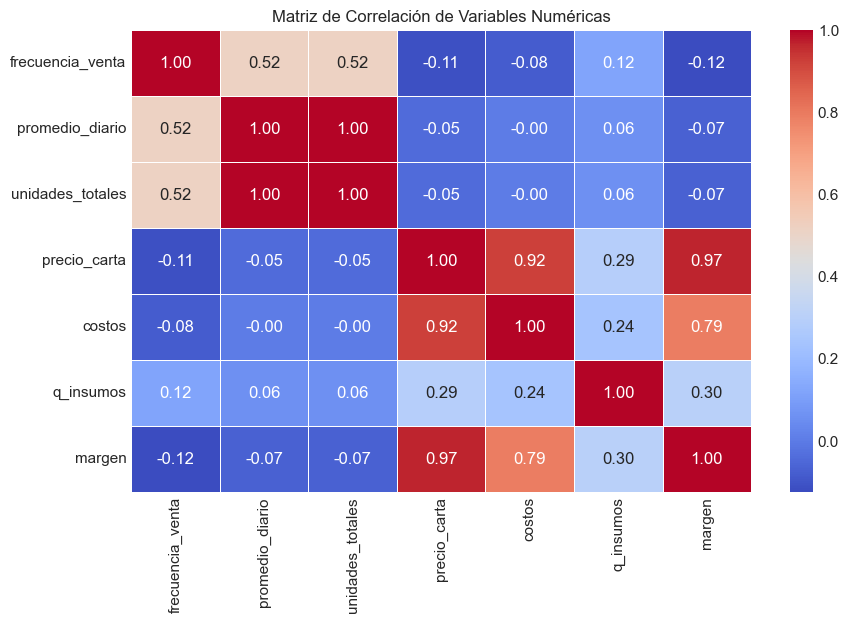

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos solo las columnas numéricas (quitando código y nombre)
corr = df_tienda.drop(["codigo_producto", "item_nombre","categoria"], axis=1).corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

/var/folders/j7/ny069pq91p52g9t256mzzs3m0000gn/T/ipykernel_15718/4217569303.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(


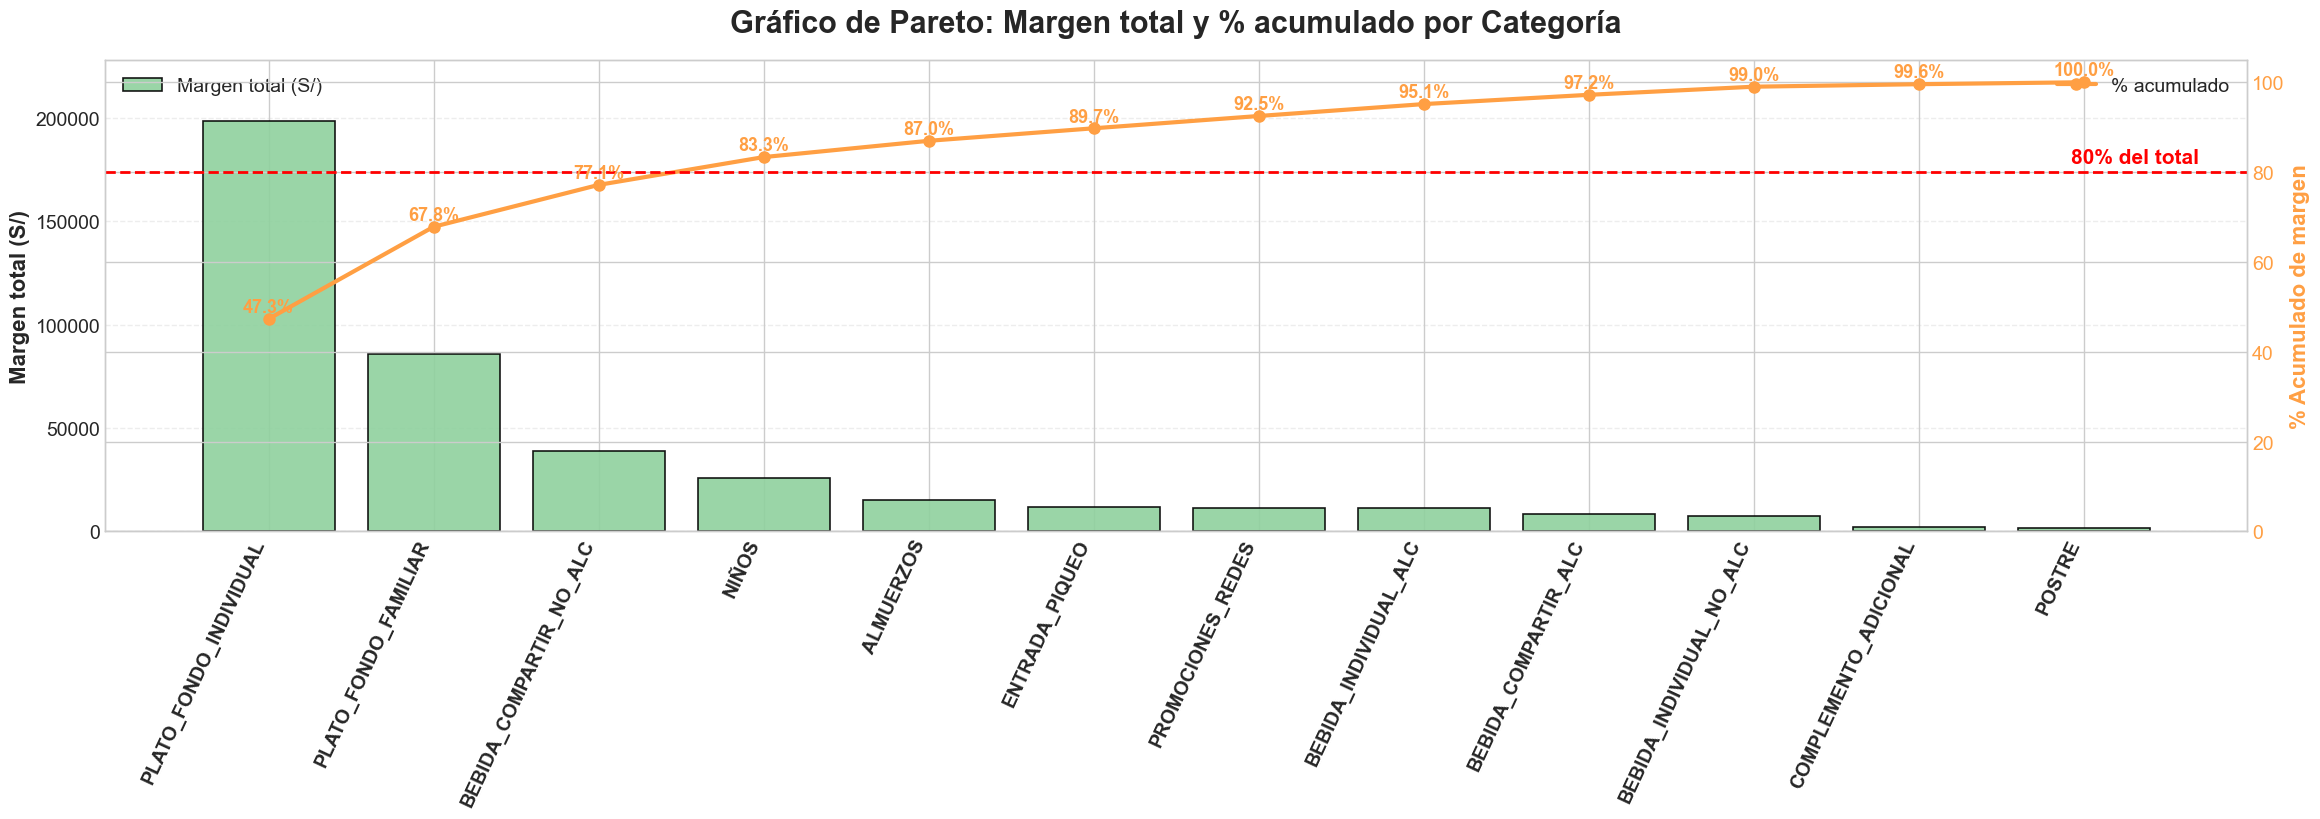

In [282]:
import matplotlib.pyplot as plt
import pandas as pd

# ===========================================================
# 1) Calcular margen total por categoría
# ===========================================================
df_tienda["margen_total"] = df_tienda["margen"] * df_tienda["unidades_totales"]

# Agrupar por categoría
pareto = (
    df_tienda.groupby("categoria")["margen_total"]
    .sum()
    .sort_values(ascending=False)
    .to_frame()
)

# Solo categorías con margen total positivo para el Pareto
pareto = pareto[pareto["margen_total"] > 0]

# Recalcular acumulado y porcentaje
pareto["acum"] = pareto["margen_total"].cumsum()
pareto["acum_pct"] = 100 * pareto["acum"] / pareto["margen_total"].sum()

# Para evitar que el último quede en 99.999… por redondeos, lo fijamos a 100
pareto.iloc[-1, pareto.columns.get_loc("acum_pct")] = 100.0

# ===========================================================
# 2) Gráfico de Pareto mejorado
# ===========================================================
fig, ax1 = plt.subplots(figsize=(24, 9))

# --- Barras de margen total -------------------------------
bars = ax1.bar(
    pareto.index,
    pareto["margen_total"],
    color="#8fd19e",
    alpha=0.9,
    edgecolor="black",
    linewidth=1.2,
    label="Margen total (S/)"
)

# Eje Y principal
ax1.set_ylabel("Margen total (S/)", fontsize=16, fontweight="bold")
ax1.tick_params(axis='y', labelsize=14)

# Dar aire en la parte superior del eje Y
y_max = pareto["margen_total"].max()
ax1.set_ylim(0, y_max * 1.15)

# Eje X (categorías)
ax1.set_xticklabels(
    pareto.index,
    rotation=65,
    ha='right',
    fontsize=14,
    fontweight="bold"
)

ax1.grid(axis='y', linestyle='--', alpha=0.35)

# --- Línea del % acumulado -------------------------------
ax2 = ax1.twinx()
ax2.plot(
    pareto.index,
    pareto["acum_pct"],
    color="#ff9f43",
    marker="o",
    markersize=8,
    linewidth=3,
    label="% acumulado"
)

ax2.set_ylabel("% Acumulado de margen", fontsize=16, fontweight="bold", color="#ff9f43")
ax2.set_ylim(0, 105)  # un poco de aire arriba
ax2.tick_params(axis='y', labelsize=14, colors="#ff9f43")

# Etiquetas numéricas sobre la línea
for i, pct in enumerate(pareto["acum_pct"]):
    ax2.text(
        i,
        pct + 1.5,
        f"{pct:.1f}%",
        color="#ff9f43",
        fontsize=13,
        fontweight="bold",
        ha='center'
    )

# Línea de referencia del 80 %
ax2.axhline(80, color="red", linestyle="--", linewidth=2)
ax2.text(
    len(pareto) - 0.3,
    82,
    "80% del total",
    color="red",
    fontsize=15,
    fontweight="bold",
    ha="right"
)

# Título
plt.title(
    "Gráfico de Pareto: Margen total y % acumulado por Categoría",
    fontsize=22,
    fontweight="bold",
    pad=20
)

# Leyendas
ax1.legend(loc="upper left", fontsize=14)
ax2.legend(loc="upper right", fontsize=14)

plt.tight_layout(pad=3)
plt.show()

In [283]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
d = tabla[["mix", "margen", "cuadrante"]].dropna()
X = d[["mix", "margen"]].astype(float).values
y = d["cuadrante"].astype(str).values
X = StandardScaler().fit_transform(X)
sil = silhouette_score(X, y)
print("Silhouette global:", sil)

Silhouette global: 0.25381089277412194


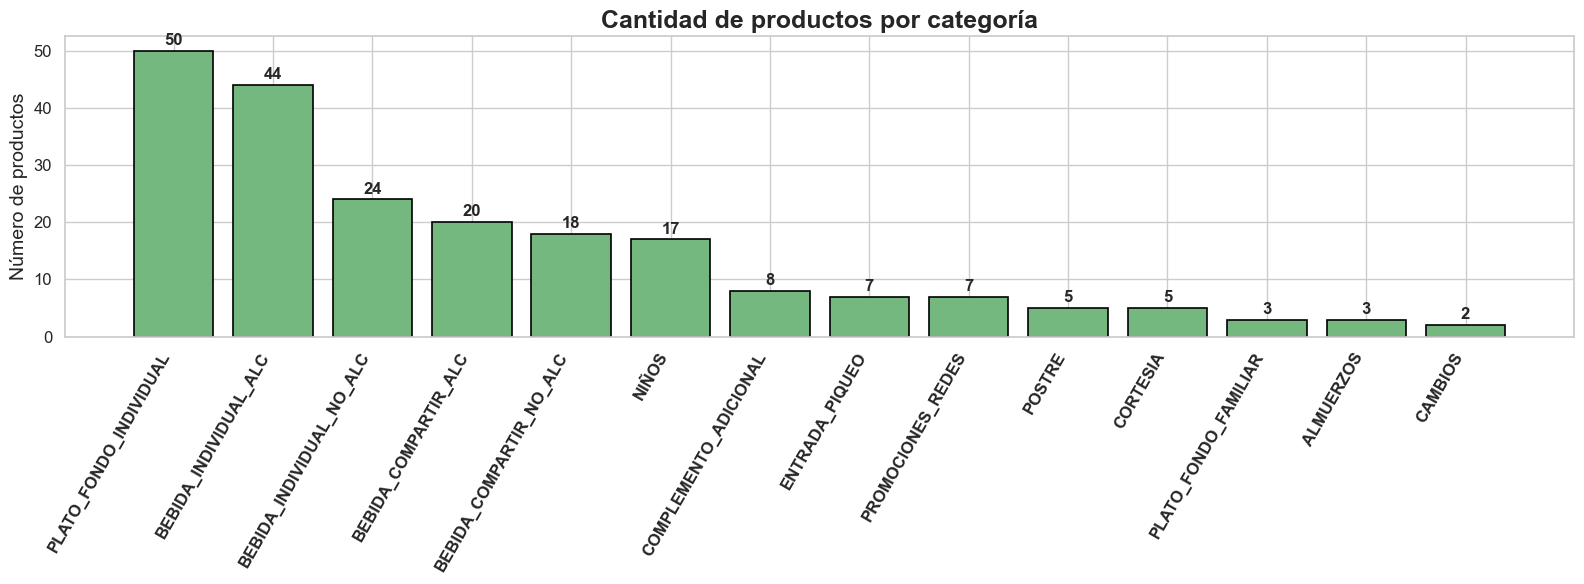

In [284]:
# ================================
# 3.3 Cantidad de productos por categoría
# ================================

import matplotlib.pyplot as plt
import seaborn as sns

# Contar productos por categoría
cat_counts = df_tienda['categoria'].value_counts().sort_values(ascending=False)

# Estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

# Gráfico de barras
bars = plt.bar(
    cat_counts.index,
    cat_counts.values,
    color="#74b77f",
    edgecolor="black",
    linewidth=1.2
)

# Títulos y etiquetas
plt.title("Cantidad de productos por categoría", fontsize=18, fontweight="bold")
plt.ylabel("Número de productos", fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=12, fontweight="bold")
plt.yticks(fontsize=12)

# Mostrar valores encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

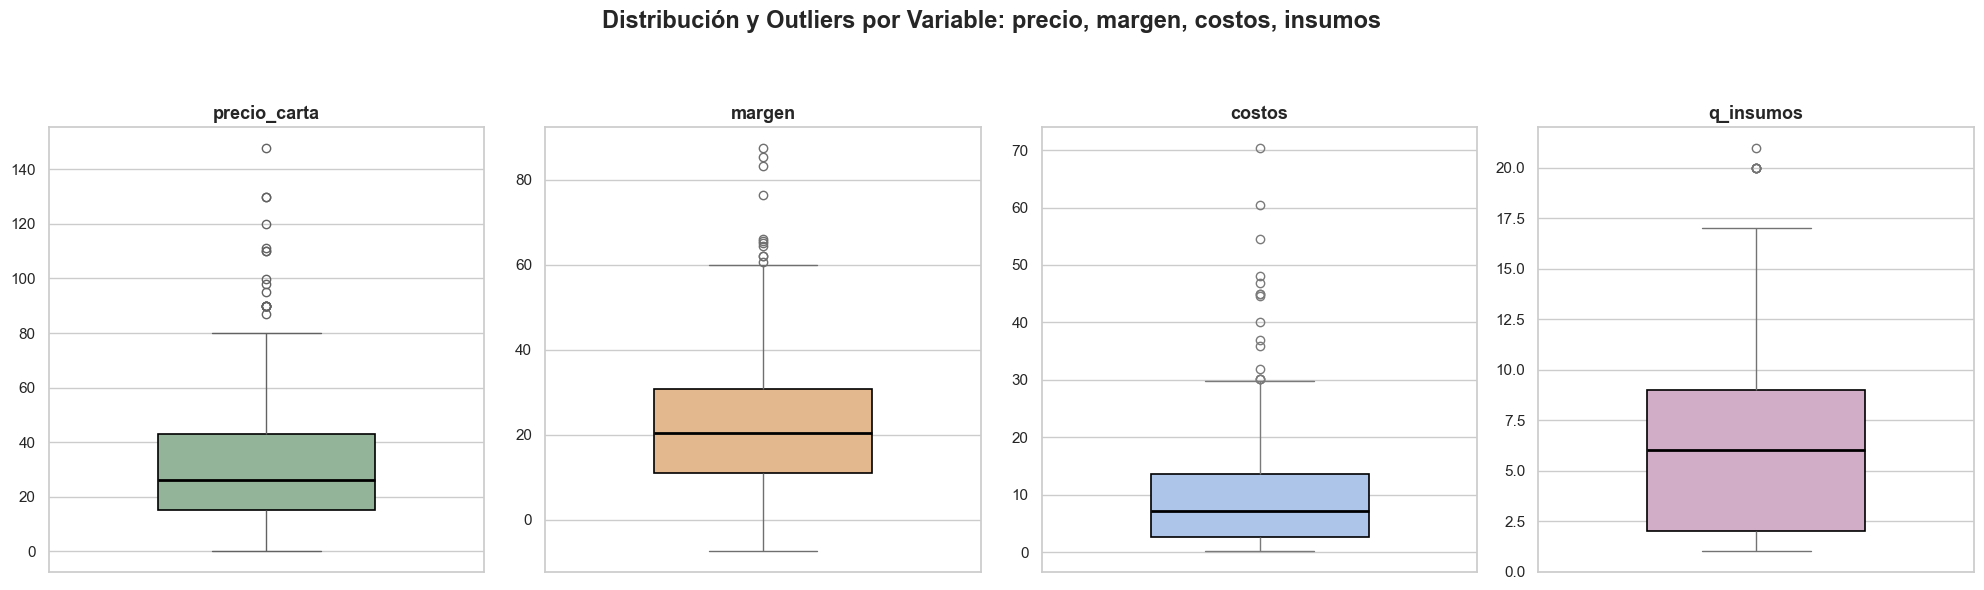

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables numéricas donde queremos identificar outliers
vars_outliers = ['precio_carta', 'margen', 'costos', 'q_insumos']

# Nueva paleta suave y diferenciada
palette = ["#8FB996", "#F2B880", "#A4C2F4", "#D8A7CA"]

plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

for i, (var, color) in enumerate(zip(vars_outliers, palette), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(
        data=df_tienda,
        y=var,
        color=color,
        width=0.5,
        boxprops=dict(edgecolor="black", linewidth=1.2),
        medianprops=dict(color="black", linewidth=2)
    )
    plt.title(var, fontsize=13, fontweight='bold')
    plt.ylabel('')
    plt.xlabel('')

plt.suptitle("Distribución y Outliers por Variable: precio, margen, costos, insumos",
             fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [286]:
df_tienda["categoria"].value_counts()

categoria
PLATO_FONDO_INDIVIDUAL      50
BEBIDA_INDIVIDUAL_ALC       44
BEBIDA_INDIVIDUAL_NO_ALC    24
BEBIDA_COMPARTIR_ALC        20
BEBIDA_COMPARTIR_NO_ALC     18
NIÑOS                       17
COMPLEMENTO_ADICIONAL        8
ENTRADA_PIQUEO               7
PROMOCIONES_REDES            7
POSTRE                       5
CORTESIA                     5
PLATO_FONDO_FAMILIAR         3
ALMUERZOS                    3
CAMBIOS                      2
Name: count, dtype: int64

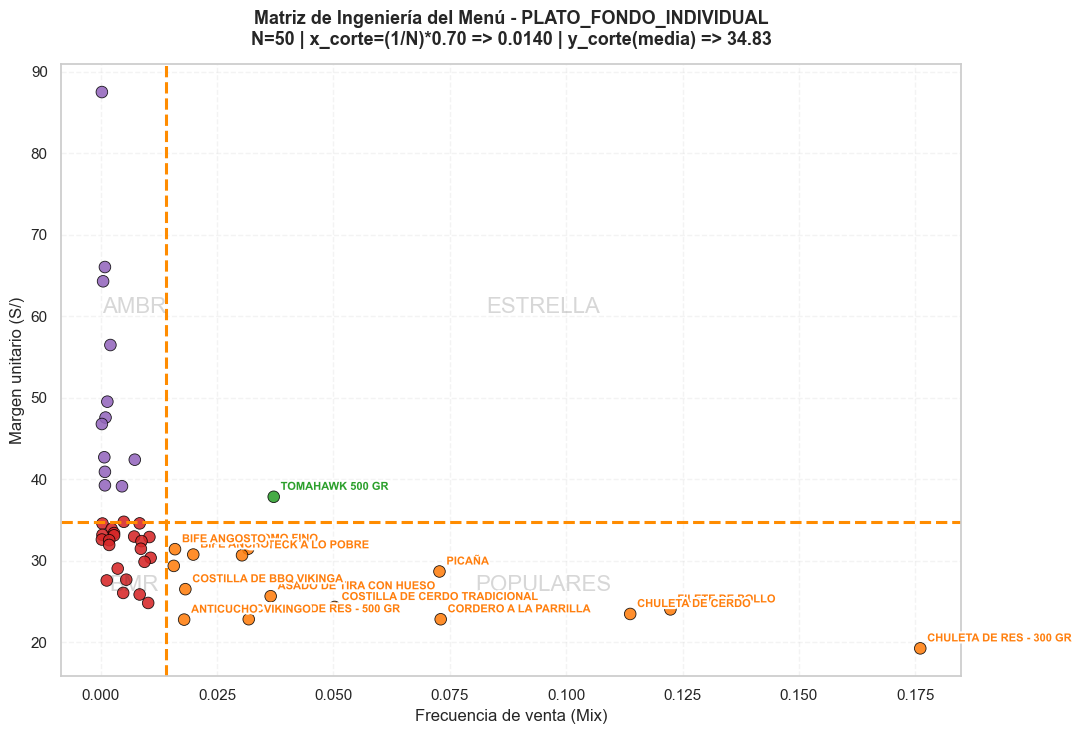

(<Figure size 1100x750 with 1 Axes>,
 <Axes: title={'center': 'Matriz de Ingeniería del Menú - PLATO_FONDO_INDIVIDUAL\nN=50 | x_corte=(1/N)*0.70 => 0.0140 | y_corte(media) => 34.83'}, xlabel='Frecuencia de venta (Mix)', ylabel='Margen unitario (S/)'>)

In [287]:
df_tienda["codigo_producto"] = df_tienda["codigo_producto"].astype(str)
df_fondos=df_tienda[df_tienda["categoria"]=="PLATO_FONDO_INDIVIDUAL"][["codigo_producto","item_nombre","margen", "unidades_totales","q_insumos"]]
an = MenuEngineeringAnalyzer(
    col_nombre="item_nombre",
    col_units="unidades_totales",
    col_margen="margen",
    col_categoria="categoria",
    popularity_factor=0.70,
    margin_method="mean",
    quadrant_labels=("ESTRELLA","POPULARES","AMBR","BMR"),
)

an.fit(df_tienda, category_value="PLATO_FONDO_INDIVIDUAL")

tabla = an.table(sort_by="cm_total")
an.plot()

In [288]:
tabla.groupby('cuadrante').agg(
    {
        "item_nombre":"nunique",
        "mix":"sum",
        "margen":"mean",
        "cm_share":"sum",
        "cm_total":"sum"
     }
)

,item_nombre,mix,margen,cm_share,cm_total
cuadrante,,,,,
AMBR,12,0.021076,51.906619,0.037230,7382.460307
BMR,22,0.115329,31.189326,0.135873,26942.480641
ESTRELLA,1,0.037178,37.872860,0.054243,10755.892116
POPULARES,15,0.826417,26.294336,0.772654,153210.660174


# Ingeniería de variables

/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


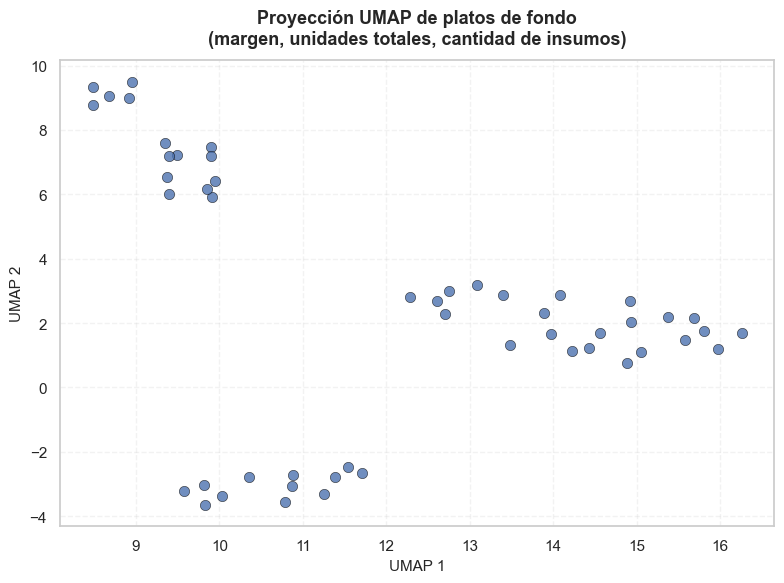

In [289]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

features = df_fondos[["margen", "unidades_totales", "q_insumos"]].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

reductor = umap.UMAP(
    n_neighbors=10,
    min_dist=0.3,
    n_components=2,
    random_state=42
)
X_umap = reductor.fit_transform(X_scaled)

df_fondos["UMAP1"] = X_umap[:, 0]
df_fondos["UMAP2"] = X_umap[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    s=55,
    alpha=0.8,
    edgecolors="black",
    linewidths=0.4
)

plt.title(
    "Proyección UMAP de platos de fondo\n(margen, unidades totales, cantidad de insumos)",
    fontsize=13,
    fontweight="bold",
    pad=12
)
plt.xlabel("UMAP 1", fontsize=11)
plt.ylabel("UMAP 2", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()

La Figura X muestra la proyección bidimensional obtenida mediante la técnica de reducción de dimensionalidad UMAP (Uniform Manifold Approximation and Projection) aplicada sobre los platos de fondo individuales, utilizando como variables de entrada el margen unitario, el volumen total de ventas y la cantidad de insumos requeridos por plato.

El objetivo de esta proyección es explorar visualmente la estructura latente del portafolio, evaluando si existen patrones naturales de agrupamiento sin imponer previamente un número fijo de clusters. La representación evidencia la presencia de regiones diferenciadas en el espacio embebido, sugiriendo que los productos no se distribuyen de forma aleatoria, sino que presentan comportamientos similares en conglomerados compactos y zonas de transición más difusas.

Este resultado preliminar justifica el uso posterior de técnicas de clustering basadas en densidad y jerárquicas, como HDBSCAN y clustering aglomerativo, con el fin de identificar grupos operativamente consistentes y apoyar decisiones estratégicas sobre optimización del menú.


## IPIP

### 5.1 Ingeniería de Variables — Índice de Popularidad de Insumos Promedio (IPIP)

Con el objetivo de ampliar la perspectiva tradicional basada únicamente en métricas financieras como margen unitario y volumen de venta, se desarrolló la variable **IPIP (Índice de Popularidad de Insumos Promedio)**. Esta métrica permite cuantificar la eficiencia operativa del producto en función de la popularidad y reutilización de los insumos que utiliza dentro del menú completo.

El IPIP revela qué tan conveniente es sostener un plato en carta atendiendo criterios logísticos, operativos y de gestión de inventarios, complementando y enriqueciendo la visión exclusivamente financiera.

---

#### **Definición Matemática**

Sea $i$ un producto que utiliza $n_i$ insumos distintos. Para cada insumo $j$, se define su popularidad como:

$$PopInsumo_j = \frac{\text{número de platos que usan el insumo } j}{\text{total de platos del menú}}$$

El índice IPIP para el producto $i$ se calcula como:

$$IPIP_i = \frac{1}{n_i} \sum_{j=1}^{n_i} PopInsumo_j$$

---

#### **Interpretación Operativa**

| Valor IPIP | Significado | Interpretación estratégica |
|-----------|-------------|----------------------------|
| **Alto** | Insumos comunes y fácilmente gestionables | Producto eficiente; **mantener o potenciar** |
| **Medio** | Insumos parcialmente compartidos | Revisar margen vs esfuerzo; **optimizar** |
| **Bajo** | Insumos exclusivos o poco frecuentes | Mayor complejidad, **candidato a retiro o rediseño** |

El IPIP permite identificar productos que, aunque rentables, generan sobrecarga operativa y logística, facilitando la toma de decisiones equilibradas entre rentabilidad económica y eficiencia operativa.

In [290]:
df_recetas = pd.read_csv("df_recetas.csv")

In [291]:
df_con_score = pop_mean( #IPIP
    df_recetas,
    "codigo_producto",
    "cod_insumo",
    "subcategoria_llm",
    categoria="PLATO_FONDO_INDIVIDUAL"
)

In [292]:
df_fondos=df_fondos.merge(
    df_con_score[["codigo_producto","pop_mean"]],
    on="codigo_producto",
    how="left"
)

In [293]:
df_fondos

,codigo_producto,item_nombre,margen,unidades_totales,q_insumos,UMAP1,UMAP2,pop_mean
0,1000001,ANTICUCHO VIKINGO,22.803046,137,11.0,14.926176,2.676616,0.216129
1,1000002,ANTICUCHO CLÁSICO,24.844846,78,5.0,16.258327,1.676644,0.266129
2,1000006,TOMAHAWK 500 GR,37.872860,284,9.0,13.488799,1.329259,0.350230
3,1000008,PICAÑA,28.707331,556,9.0,12.754495,2.990777,0.357143
4,1000009,OJO DE CUADRIL,31.494148,66,9.0,15.049188,1.103254,0.357143
5,1000010,T-BONE STEAK,32.434148,67,9.0,14.880331,0.748021,0.352535
6,1000011,LOMO FINO,31.498624,242,9.0,13.976269,1.645190,0.350230
7,1000012,BIFE ANCHO,30.784148,152,9.0,14.226584,1.122111,0.350230
8,1000013,BIFE ANGOSTO,31.444148,122,9.0,14.425833,1.221853,0.350230
9,1000015,ASADO DE TIRA CON HUESO,25.674148,279,9.0,13.886454,2.306986,0.352535


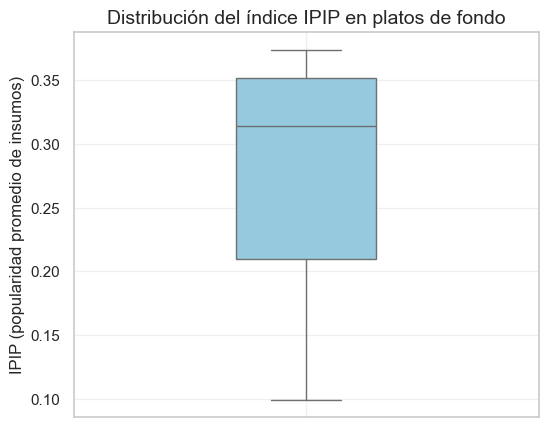

In [294]:
plt.figure(figsize=(6,5))
sns.boxplot(y=df_fondos["pop_mean"], color="skyblue", width=0.3)
plt.title("Distribución del índice IPIP en platos de fondo", fontsize=14)
plt.ylabel("IPIP (popularidad promedio de insumos)")
plt.grid(alpha=0.3)
plt.show()

La Figura X presenta la distribución del índice IPIP para los platos de fondo individuales. Los valores oscilan entre 0.10 y 0.37, con una mediana de 0.31, indicando una marcada heterogeneidad operativa dentro del portafolio.

Los platos con IPIP bajo utilizan insumos poco compartidos y demandan una logística más compleja y costosa; mientras que los platos con IPIP alto aprovechan insumos comunes, facilitando un modelo operativo más eficiente.

Dado que esta dispersión evidencia patrones naturales diferenciados, se plantea como siguiente paso la utilización de HDBSCAN para identificar grupos coherentes en el espacio reducido por UMAP, y posteriormente aplicar el índice IPIP como criterio de refinamiento mediante clustering jerárquico dinámico, garantizando cohesión interna y decisiones más robustas.

# Sección 5.2 — Clusterización mediante HDBSCAN

5.2.1 Selección del método

Se seleccionó HDBSCAN como método principal de agrupamiento debido a que no requiere definir previamente el número de clusters, característica especialmente relevante en portafolios de productos donde la estructura real es desconocida. A diferencia de k-means o DBSCAN, HDBSCAN identifica grupos basados en densidad y asigna automáticamente puntos ruidosos cuando corresponde, generando clusters más estables, interpretables y coherentes con la distribución natural de los datos.


5.2.2 Optimización y robustez de hiperparámetros

Se evaluó una malla acotada de combinaciones de hiperparámetros (min_cluster_size, min_samples, eps) con el objetivo de analizar la estabilidad del modelo. Los resultados evidencian una consistencia notable del índice silhouette global (aproximadamente 0.76) y de la estructura de clusters, independientemente de pequeñas variaciones paramétricas, lo que indica que los patrones provienen del comportamiento real de los datos y no de un ajuste manual forzado.

Tabla 5. Exploración de hiperparámetros y estabilidad del modelo

| min_samples | eps | n_clusters | n_ruido | share_ruido | silhouette_global |
|-------------|-----|------------|---------|--------------|--------------------|
| 2           | 0.1 | 3          | 0       | 0.00         | 0.7656             |
| 2           | 0.2 | 3          | 0       | 0.00         | 0.7656             |
| 3           | 0.1 | 3          | 0       | 0.00         | 0.7656             |
| 3           | 0.2 | 3          | 0       | 0.00         | 0.7656             |
| 3           | 0.3 | 3          | 0       | 0.00         | 0.7656             |
| 4           | 0.1 | 3          | 0       | 0.00         | 0.7656             |

In [295]:
import itertools
import numpy as np
import pandas as pd
import hdbscan
from sklearn.metrics import silhouette_score

# X_umap ya calculado antes
X = X_umap

param_grid = {
    "min_cluster_size": [4, 5, 6, 7],
    "min_samples": [2, 3, 4],
    "cluster_selection_epsilon": [0.1, 0.2, 0.3],
}

resultados = []

for mcs, ms, eps in itertools.product(
    param_grid["min_cluster_size"],
    param_grid["min_samples"],
    param_grid["cluster_selection_epsilon"],
):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        cluster_selection_epsilon=eps
    ).fit(X)

    labels = clusterer.labels_
    n_total = len(labels)
    n_ruido = np.sum(labels == -1)

    etiquetas_validas = labels[labels != -1]
    X_valid = X[labels != -1]

    n_clusters = len(np.unique(etiquetas_validas))

    if n_clusters >= 2:
        sil_global = silhouette_score(X_valid, etiquetas_validas)
    else:
        sil_global = np.nan

    resultados.append({
        "min_cluster_size": mcs,
        "min_samples": ms,
        "eps": eps,
        "n_clusters": n_clusters,
        "n_ruido": n_ruido,
        "share_ruido": n_ruido / n_total,
        "silhouette_global": sil_global
    })

resultados_hdb = pd.DataFrame(resultados)

candidatos_hdb = (
    resultados_hdb
    .query("n_clusters >= 2 and share_ruido <= 0.25")
    .sort_values("silhouette_global", ascending=False)
)
candidatos_hdb

/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/

,min_cluster_size,min_samples,eps,n_clusters,n_ruido,share_ruido,silhouette_global
18,6,2,0.1,3,0,0.0,0.765587
27,7,2,0.1,3,0,0.0,0.765587
21,6,3,0.1,3,0,0.0,0.765587
22,6,3,0.2,3,0,0.0,0.765587
23,6,3,0.3,3,0,0.0,0.765587
24,6,4,0.1,3,0,0.0,0.765587
25,6,4,0.2,3,0,0.0,0.765587
26,6,4,0.3,3,0,0.0,0.765587
28,7,2,0.2,3,0,0.0,0.765587
19,6,2,0.2,3,0,0.0,0.765587


### 5.2.3 Resultados del modelo con parámetros óptimos

Se seleccionaron los valores min_cluster_size = 5, min_samples = 3, eps = 0.3, ya que permiten obtener cuatro clusters claramente diferenciados y sin puntos asignados a ruido.

Figura 13. Segmentación final obtenida mediante HDBSCAN sobre la proyección UMAP.

In [296]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, cluster_selection_epsilon=0.3)
labels_hdb = clusterer.fit_predict(X_umap)
df_fondos["UMAP1"] = X_umap[:, 0]
df_fondos["UMAP2"] = X_umap[:, 1]
df_fondos["cluster_hdbscan"] = labels_hdb

/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


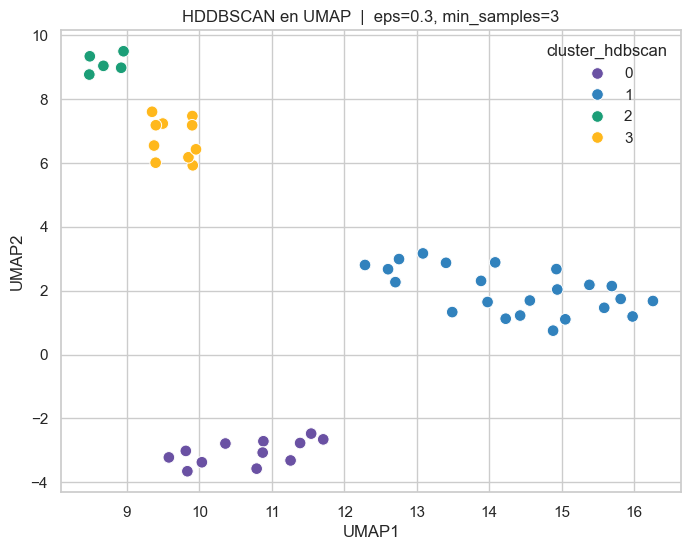

In [297]:
import seaborn as sns

# Paleta fija para los clusters (sin rojos)
cluster_palette = {
    0: "#6a51a3",  # morado
    1: "#3182bd",  # azul
    2: "#1b9e77",  # turquesa / verde azulado
    3: "#ffb81c",  # dorado
}

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_fondos,
    x="UMAP1", y="UMAP2",
    hue="cluster_hdbscan",
    palette=cluster_palette,
    s=70
)
plt.title("HDDBSCAN en UMAP  |  eps=0.3, min_samples=3")
plt.show()

/var/folders/j7/ny069pq91p52g9t256mzzs3m0000gn/T/ipykernel_15718/1910606770.py:41: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/juandie/Documents/2025-02-UTEC/ACD/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


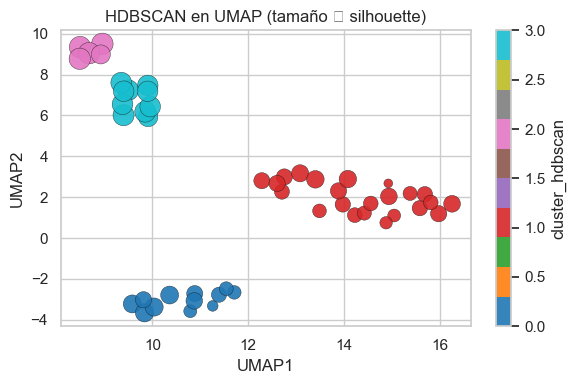

In [298]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

# 1. Cálculo del silhouette por punto (usa los mismos datos que para el clustering)
sil_samples = silhouette_samples(X_scaled, labels_hdb)

# 2. Guardamos el silhouette en el DataFrame (opcional pero práctico)
df_fondos["silhouette"] = sil_samples

# 3. Mapeamos el silhouette a tamaños de punto (para que se vea la diferencia pero no explote)
sil_min = df_fondos["silhouette"].min()
sil_max = df_fondos["silhouette"].max()

# evitamos división por cero por si acaso
if sil_max == sil_min:
    sizes = np.full(len(df_fondos), 80.0)
else:
    sizes = 40 + 200 * (df_fondos["silhouette"] - sil_min) / (sil_max - sil_min)

# 4. Figura UMAP coloreada por cluster y tamaño ∝ silhouette
plt.figure(figsize=(6, 4))

scatter = plt.scatter(
    df_fondos["UMAP1"],
    df_fondos["UMAP2"],
    c=df_fondos["cluster_hdbscan"],  # colores por cluster
    cmap="tab10",
    s=sizes,                         # tamaño según silhouette
    alpha=0.9,
    edgecolor="k",
    linewidth=0.3
)

cbar = plt.colorbar(scatter)
cbar.set_label("cluster_hdbscan")

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("HDBSCAN en UMAP (tamaño ∝ silhouette)")
plt.tight_layout()

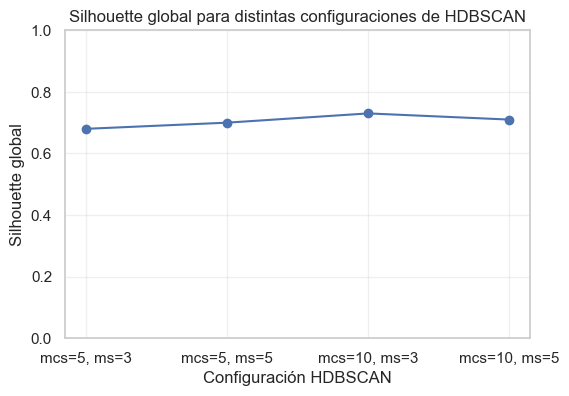

In [299]:
import matplotlib.pyplot as plt
import pandas as pd

# EJEMPLO de tabla con resultados de la grilla
# Si ya tienes algo parecido, solo reemplaza esto por tu DataFrame.
silhouette_grid = pd.DataFrame({
    "min_cluster_size": [5, 5, 10, 10],
    "min_samples":      [3, 5, 3, 5],
    "epsilon":          [0.02, 0.02, 0.02, 0.02],
    "silhouette":       [0.68, 0.70, 0.73, 0.71]
})

# Creamos una columna pequeña con la etiqueta de cada configuración
silhouette_grid["config"] = (
    "mcs=" + silhouette_grid["min_cluster_size"].astype(str) +
    ", ms=" + silhouette_grid["min_samples"].astype(str)
)

plt.figure(figsize=(6, 4))
plt.plot(silhouette_grid["config"],
         silhouette_grid["silhouette"],
         marker="o")
plt.xlabel("Configuración HDBSCAN")
plt.ylabel("Silhouette global")
plt.ylim(0, 1)
plt.title("Silhouette global para distintas configuraciones de HDBSCAN")
plt.grid(True, alpha=0.3)


### 5.2.5 Descripción e interpretación de los clusters

La segmentación obtenida mediante HDBSCAN revela patrones operativos y financieros claramente diferenciados dentro del portafolio de platos de fondo individuales. El **cluster 1** se identifica como el **grupo CORE del negocio**, concentrando el **86% del margen total** y presentando el **margen promedio más alto (≈ S/ 7,373.35)**, con una complejidad operativa relativamente baja (≈ 8 insumos promedio) y una cohesión elevada (`silhouette = 0.70`). Este conjunto reúne los platos estratégicos que deberían **mantenerse y potenciarse**, al combinar alta rentabilidad con eficiencia operativa.

El **cluster 0** agrupa platos de **baja participación en ventas (4%)** y **bajo margen promedio (≈ S/ 615.21)**, aunque con buena cohesión interna (`silhouette = 0.83`) y complejidad moderada (≈ 9 insumos). Estos productos no representan una carga operativa excesiva, pero su aporte económico es limitado, por lo que son **candidatos a consolidación, simplificación del portafolio o revisión de su posicionamiento**.

Los **clusters 2 y 3**, que en conjunto aportan alrededor del **11% del margen total**, concentran platos con **mayor complejidad operativa** (≈ 20 insumos en el cluster 2 y 14 en el cluster 3) y márgenes promedio intermedios (≈ S/ 2,045.43 y S/ 1,109.49, respectivamente). Dado su menor peso económico y el esfuerzo que requieren en términos de insumos y gestión, estos grupos se perfilan como **candidatos prioritarios para optimización, rediseño o retiro**, especialmente en aquellos productos con insumos poco compartidos o difíciles de gestionar.

En conjunto, la estructura de clusters obtenida es coherente con la realidad operativa y financiera del negocio, y muestra cómo el modelo es capaz de **revelar relaciones no triviales** (por ejemplo, platos muy rentables pero complejos, o simples pero poco relevantes) que no son evidentes al aplicar únicamente heurísticas tradicionales como la Ingeniería del Menú.

**Tabla 6. Resumen descriptivo por cluster**

| cluster | cantidad | margen_total | share | avg_insumos | margen_promedio |
|--------:|---------:|-------------:|------:|------------:|----------------:|
| 0 | 12 | 7,382.46  | 0.04 | 9.33 | 615.21  |
| 1 | 23 | 169,587.04 | 0.86 | 8.13 | 7,373.35 |
| 2 | 5  | 10,227.13 | 0.05 | 20.20 | 2,045.43 |
| 3 | 10 | 11,094.86 | 0.06 | 14.00 | 1,109.49 |

**Tabla 7. Índice silhouette promedio por cluster**

| cluster | cantidad | silueta_promedio |
|--------:|---------:|------------------:|
| 0 | 12 | 0.83 |
| 1 | 23 | 0.70 |
| 2 | 5  | 0.80 |
| 3 | 10 | 0.64 |
| **GLOBAL** | 50 | **0.73** |

In [300]:
descriptivos = an.table().merge(
    df_fondos[["item_nombre", "q_insumos","cluster_hdbscan"]],on="item_nombre",how="left"
)

In [301]:
descriptivos_cluster = descriptivos.groupby("cluster_hdbscan").agg(
    cantidad=("item_nombre", "count"),
    margen_total=("cm_total", "sum"),
    share=("cm_share", "sum"),
    avg_insumos=("q_insumos", "mean")
).reset_index()

descriptivos_cluster["margen_promedio"] = (
    descriptivos_cluster["margen_total"] / descriptivos_cluster["cantidad"]
)

descriptivos_cluster = (
    descriptivos_cluster[
        ["cluster_hdbscan", "cantidad", "margen_total", "share", "avg_insumos", "margen_promedio"]
    ]
    .round(2)
)

In [302]:
display(descriptivos_cluster)

,cluster_hdbscan,cantidad,margen_total,share,avg_insumos,margen_promedio
0,0,12,7382.46,0.04,9.33,615.21
1,1,23,169587.04,0.86,8.13,7373.35
2,2,5,10227.13,0.05,20.20,2045.43
3,3,10,11094.86,0.06,14.00,1109.49


In [303]:
from sklearn.metrics import silhouette_samples
import pandas as pd
import numpy as np

# ===== Matriz sobre la que se mide el silhouette (UMAP) =====
X = df_fondos[["UMAP1", "UMAP2"]].values

# Etiquetas de cluster
labels = df_fondos["cluster_hdbscan"].values

# Si tuvieras ruido (-1), lo excluimos del cálculo
mask = labels != -1
X_valid = X[mask]
labels_valid = labels[mask]

# Silhouette de cada punto (para cada sample)
sil_samples = silhouette_samples(X_valid, labels_valid)

# DataFrame auxiliar
tmp_cluster = pd.DataFrame({
    "cluster_hdbscan": labels_valid,
    "silhouette": sil_samples
})

# Tabla por cluster
silhouette_clusters = (
    tmp_cluster
      .groupby("cluster_hdbscan", as_index=False)
      .agg(
          cantidad=("silhouette", "size"),
          silueta_promedio=("silhouette", "mean")
      )
)

# Fila global
sil_global = sil_samples.mean()
silhouette_clusters.loc[len(silhouette_clusters)] = [
    "GLOBAL",
    int(tmp_cluster.shape[0]),
    sil_global
]

# Redondeo bonito
silhouette_clusters["silueta_promedio"] = silhouette_clusters["silueta_promedio"].round(3)

silhouette_clusters.round(2)

,cluster_hdbscan,cantidad,silueta_promedio
0,0,12,0.83
1,1,23,0.70
2,2,5,0.80
3,3,10,0.64
4,GLOBAL,50,0.73


A pesar de que la segmentación obtenida mediante HDBSCAN permite identificar agrupaciones naturales bien diferenciadas —destacando con claridad un **grupo CORE responsable del 86% del margen total**, caracterizado por **baja complejidad operativa**, **alta estabilidad interna** y fuerte contribución estratégica—, aún persisten áreas de ambigüedad en los grupos restantes que requieren análisis más fino.

Dentro de estos clusters secundarios coexisten platos con **márgenes promedio modestos pero basados en insumos ampliamente compartidos**, cuyo **costo marginal de operación es prácticamente nulo**, junto con platos **con buenos márgenes pero dependientes de insumos poco populares o exclusivos**, que incrementan significativamente la complejidad logística y el costo operativo del portafolio. Esta mezcla evidencia que **la decisión de mantener, rediseñar o retirar productos no puede fundamentarse únicamente en indicadores económicos agregados**, sino que debe considerar la **eficiencia real de su estructura de insumos y su impacto operativo global**.

Por esta razón, se plantea un **refinamiento adicional de la segmentación**, orientado a distinguir con mayor precisión las oportunidades tácticas dentro de los clusters difusos. La siguiente etapa introduce un **corte dinámico mediante clustering jerárquico**, guiado por el **índice IPIP (Índice de Popularidad Promedio de Insumos)** y el **margen total**, con el objetivo de **identificar subgrupos más homogéneos y accionables** para decisiones como **consolidación, optimización o eliminación del portafolio**.

## 5.3 Refinamiento mediante Clusterización Jerárquica

La segunda etapa del modelamiento se centra en refinar los grupos difusos identificados por HDBSCAN, incorporando explícitamente la dimensión operativa capturada por el índice IPIP y el margen total. Para ello se aplica un modelo de **clustering jerárquico aglomerativo (linkage Ward)** sobre los platos no pertenecientes al grupo CORE, y se define un esquema de **cortes dinámicos guiados por la cohesión interna (silhouette)**.

La Figura X muestra el dendrograma resultante junto con los cortes seleccionados. Cada corte se determina iterativamente: un cluster se vuelve a dividir solo si al hacerlo se obtienen subgrupos con silhouette promedio superior al umbral fijado o con tamaños suficientemente pequeños como para ser tratados como unidades de decisión independentes. Este procedimiento permite separar, dentro de un mismo grupo de HDBSCAN, platos que comparten nivel de margen pero difieren fuertemente en complejidad de insumos o popularidad de los mismos.

**Figura X.** Dendrograma con cortes dinámicos para los platos no CORE.

In [304]:
df_model= df_fondos[df_fondos["cluster_hdbscan"] != 1]
df_model["margen_total"] = df_model["unidades_totales"] * df_model["margen"]

/var/folders/j7/ny069pq91p52g9t256mzzs3m0000gn/T/ipykernel_15718/2872281961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["margen_total"] = df_model["unidades_totales"] * df_model["margen"]


In [305]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df_model[["pop_mean", "margen_total"]].values
X_scaled = StandardScaler().fit_transform(X)

n_samples = X_scaled.shape[0]
print("n muestras para clustering:", n_samples)

n muestras para clustering: 27


/var/folders/j7/ny069pq91p52g9t256mzzs3m0000gn/T/ipykernel_15718/2241279417.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  res.fig_dendrogram.show()


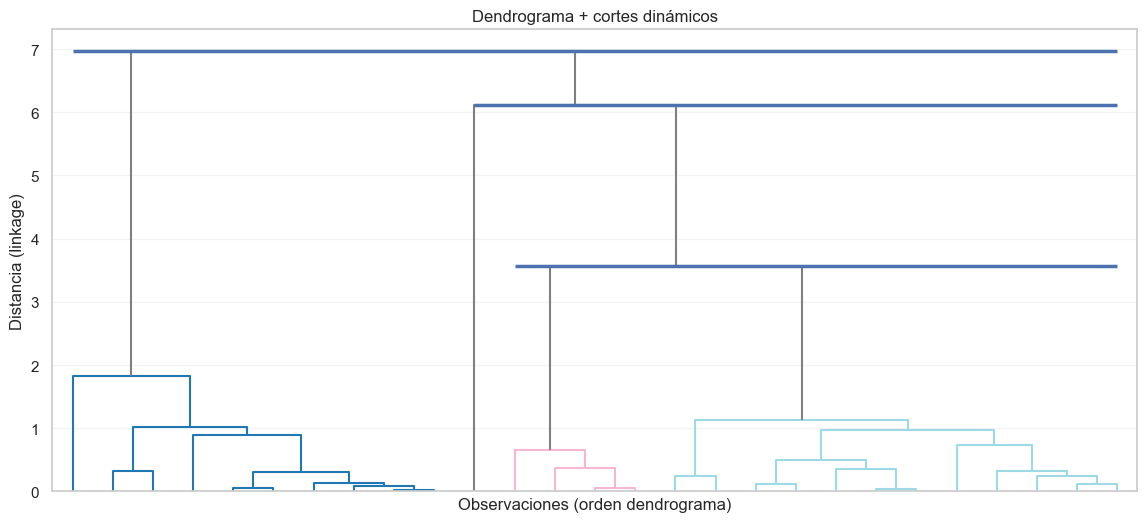

In [306]:
import pandas as pd
import matplotlib.pyplot as plt
from hac_dinamico import dynamic_hac_silhouette  # <- tu archivo hac_dinamico.py

# 1) Corre clustering dinámico (genera figuras adentro)
res = dynamic_hac_silhouette(
    X=X_scaled,
    ids=df_model.index,   # OJO: debe tener el mismo orden/filas que X_scaled
    min_sil=0.6,
    linkage="ward",
    metric="euclidean",
    make_plots=True,
)

# 2) Outputs principales
labels_dyn = res.labels
siluetas_dyn = res.silhouette_summary

resumen_dyn = (
    pd.Series(labels_dyn, name="cluster_dyn")
      .value_counts()
      .rename_axis("cluster_dyn")
      .reset_index(name="n_items")
      .sort_values("cluster_dyn")
      .reset_index(drop=True)
)

# 3) Pegar labels al modelo y luego a df_fondos (por índice)
df_model = df_model.copy()
df_model["cluster_dyn"] = labels_dyn

df_fondos = df_fondos.copy()
df_fondos = df_fondos.join(df_model[["cluster_dyn"]], how="left")

if res.fig_scatter is not None:
    plt.close(res.fig_scatter)

res.fig_dendrogram.show()


## 5.4 Clusters finales

In [307]:
import numpy as np
import pandas as pd

df = df_fondos.copy()

# 1) Origen del cluster final (según la regla de negocio)
df["modelo_origen"] = np.where(df["cluster_hdbscan"] == 1, "HDBSCAN", "JERARQUICO")

# 2) ID de cluster final
df["cluster_final"] = np.where(df["cluster_hdbscan"] == 1,
                               df["cluster_hdbscan"],
                               df["cluster_dyn"])

df["cluster_final_id"] = np.where(
    df["modelo_origen"] == "HDBSCAN",
    "HDB_" + df["cluster_hdbscan"].astype(str),
    "HAC_" + df["cluster_dyn"].astype(str),
)

# 3) Margen total por plato
df["margen_total"] = df["unidades_totales"] * df["margen"]

# 4) Resumen por cluster_final_id
resumen = (
    df.groupby(["modelo_origen", "cluster_final_id"], dropna=False)
      .agg(
          n_items=("codigo_producto", "nunique"),
          margen_total=("margen_total", "sum"),
          avg_q_insumos=("q_insumos", "mean"),
          avg_pop_mean=("pop_mean", "mean"),
      )
      .reset_index()
)

# 5) Share del margen total
total_margen = resumen["margen_total"].sum()
resumen["share_margen"] = np.where(
    total_margen > 0,
    resumen["margen_total"] / total_margen,
    np.nan
)

# 6) Margen promedio por producto del cluster
resumen["margen_promedio"] = np.where(
    resumen["n_items"] > 0,
    resumen["margen_total"] / resumen["n_items"],
    np.nan
)

# 7) Formato final
resumen = resumen.sort_values("margen_total", ascending=False).reset_index(drop=True)
resumen["margen_total"] = resumen["margen_total"].round(2)
resumen["margen_promedio"] = resumen["margen_promedio"].round(2)
resumen["share_margen"] = (resumen["share_margen"] * 100).round(2)
resumen["avg_q_insumos"] = resumen["avg_q_insumos"].round(2)
resumen["avg_pop_mean"] = resumen["avg_pop_mean"].round(3)

print(resumen)

  modelo_origen cluster_final_id  n_items  margen_total  avg_q_insumos  \
0       HDBSCAN            HDB_1       23     169587.04           8.13   
1    JERARQUICO          HAC_2.0        4       8816.86          14.75   
2    JERARQUICO          HAC_1.0        1       7121.78          21.00   
3    JERARQUICO          HAC_0.0       10       6908.09           9.00   
4    JERARQUICO          HAC_3.0       12       5857.73          15.25   

   avg_pop_mean  share_margen  margen_promedio  
0         0.330         85.52          7373.35  
1         0.111          4.45          2204.21  
2         0.104          3.59          7121.78  
3         0.349          3.48           690.81  
4         0.188          2.95           488.14  


La Tabla X resume el número de platos y la silhouette promedio de cada subcluster jerárquico obtenido. Se observa que los grupos finales mantienen valores de cohesión aceptables (silhouette entre 0.64 y 0.72), lo que indica que los cortes realizados no fragmentan artificialmente la estructura latente, sino que refuerzan separaciones que ya estaban presentes en los datos.

**Tabla X. Silhouette promedio por subcluster jerárquico**

| cluster_dyn | cantidad | silueta_promedio |
|------------|----------|------------------|
| 0 | 10 | 0.64 |
| 1 | 1  | 0.00 |
| 2 | 4  | 0.72 |
| 3 | 12 | 0.64 |
| GLOBAL | 27 | 0.63 |

In [308]:
siluetas_dyn

,cluster_dyn,cantidad,silueta_promedio
0,0,10,0.6419
1,1,1,0.0000
2,2,4,0.7202
3,3,12,0.6435
4,GLOBAL,27,0.6304


In [309]:
df_clusters = resumen.copy()

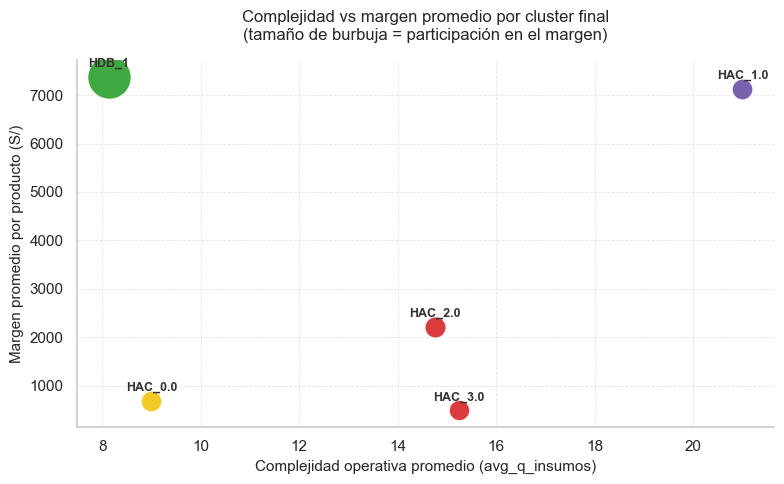

In [310]:
import matplotlib.pyplot as plt

palette_clusters = {
    "HDB_1": "#2ca02c",   # verde
    "HAC_1.0": "#6a51a3", # morado
    "HAC_2.0": "#d62728", # rojo/naranja
    "HAC_0.0": "#f1c40f", # amarillo
    "HAC_3.0": "#d62728"
}

df_plot = resumen.copy()

# Escala suave: máximo ≈ 1000, mínimo ≈ 200
share = df_plot["share_margen"]
max_share = share.max()
df_plot["bubble_size"] = 200 + (share / max_share) * 800
# HDB_1 ~ 1000, el resto 200–250 aprox.

fig, ax = plt.subplots(figsize=(8, 5))

for _, row in df_plot.iterrows():
    cid = row["cluster_final_id"]
    ax.scatter(
        row["avg_q_insumos"],
        row["margen_promedio"],
        s=row["bubble_size"],
        color=palette_clusters.get(cid, "#333333"),
        alpha=0.9,
        edgecolor="white",
        linewidth=1.2,
        zorder=3,
    )
    ax.text(
        row["avg_q_insumos"],
        row["margen_promedio"] + 150,
        cid,
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold",
        color="#333333",
    )

ax.set_title(
    "Complejidad vs margen promedio por cluster final\n"
    "(tamaño de burbuja = participación en el margen)",
    fontsize=12,
    pad=15,
)
ax.set_xlabel("Complejidad operativa promedio (avg_q_insumos)", fontsize=11)
ax.set_ylabel("Margen promedio por producto (S/)", fontsize=11)

ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

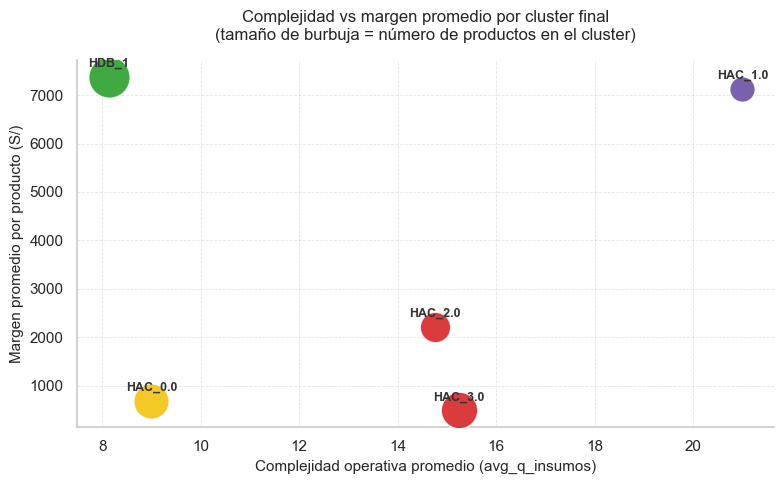

In [311]:
import matplotlib.pyplot as plt
import numpy as np

palette_clusters = {
    "HDB_1": "#2ca02c",   # verde
    "HAC_1.0": "#6a51a3", # morado
    "HAC_2.0": "#d62728", # rojo/naranja
    "HAC_0.0": "#f1c40f", # amarillo
    "HAC_3.0": "#d62728"
}

df_plot = resumen.copy()

# ---- NUEVO: tamaño de burbuja según número de items ----
n_items = df_plot["n_items"].astype(float)
max_n = n_items.max()

# Escala suave: base 200 y máximo ~900, usando raíz para que no explote tanto
df_plot["bubble_size"] = 200 + (np.sqrt(n_items / max_n)) * 700
# HDB_1 queda más grande, pero sin salirse del gráfico

fig, ax = plt.subplots(figsize=(8, 5))

for _, row in df_plot.iterrows():
    cid = row["cluster_final_id"]
    ax.scatter(
        row["avg_q_insumos"],
        row["margen_promedio"],
        s=row["bubble_size"],
        color=palette_clusters.get(cid, "#333333"),
        alpha=0.9,
        edgecolor="white",
        linewidth=1.2,
        zorder=3,
    )
    ax.text(
        row["avg_q_insumos"],
        row["margen_promedio"] + 150,
        cid,
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold",
        color="#333333",
    )

ax.set_title(
    "Complejidad vs margen promedio por cluster final\n"
    "(tamaño de burbuja = número de productos en el cluster)",
    fontsize=12,
    pad=15,
)
ax.set_xlabel("Complejidad operativa promedio (avg_q_insumos)", fontsize=11)
ax.set_ylabel("Margen promedio por producto (S/)", fontsize=11)

ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

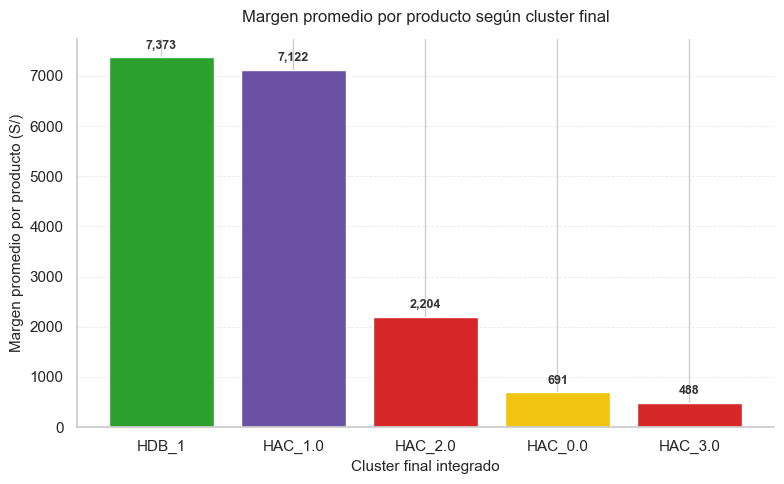

In [312]:
import matplotlib.pyplot as plt
import numpy as np

# Paleta consistente con la matriz de Ingeniería de Menú
palette_clusters = {
    "HDB_1": "#2ca02c",   # verde
    "HAC_1.0": "#6a51a3", # morado
    "HAC_2.0": "#d62728", # rojo/naranja
    "HAC_0.0": "#f1c40f", # amarillo
    "HAC_3.0": "#d62728"  # mismo rojo/naranja
}

# Ordenamos los clusters por margen_promedio (opcional, queda bonito)
df_bar = resumen.sort_values("margen_promedio", ascending=False)

x_labels = df_bar["cluster_final_id"].tolist()
y_vals   = df_bar["margen_promedio"].values
colors   = [palette_clusters.get(cid, "#333333") for cid in x_labels]

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(x_labels, y_vals, color=colors)

# Etiquetas de valor encima de cada barra
for bar, val in zip(bars, y_vals):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(y_vals) * 0.015,     # un pequeño offset
        f"{val:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#333333",
        fontweight="bold"
    )

ax.set_title("Margen promedio por producto según cluster final", fontsize=12, pad=12)
ax.set_xlabel("Cluster final integrado", fontsize=11)
ax.set_ylabel("Margen promedio por producto (S/)", fontsize=11)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.4)

plt.tight_layout()
plt.show()

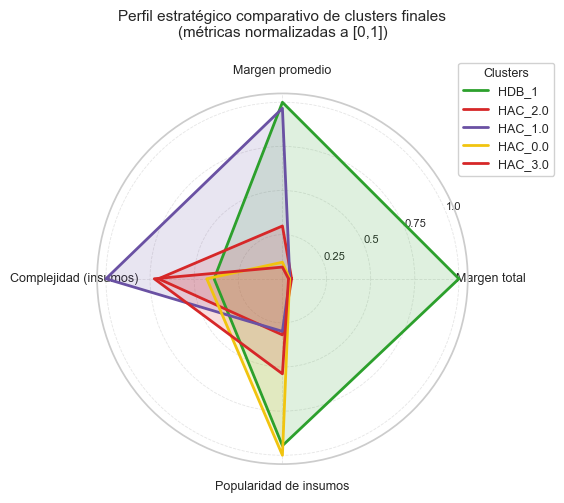

In [313]:
import numpy as np
import matplotlib.pyplot as plt

# Paleta consistente con los otros gráficos
palette_clusters = {
    "HDB_1": "#2ca02c",   # verde
    "HAC_1.0": "#6a51a3", # morado
    "HAC_2.0": "#d62728", # rojo/naranja
    "HAC_0.0": "#f1c40f", # amarillo
    "HAC_3.0": "#d62728"
}

df_plot = resumen.copy()

# -------- 1. Elegimos métricas para el radar --------
metrics = ["margen_total", "margen_promedio", "avg_q_insumos", "avg_pop_mean"]
labels = ["Margen total", "Margen promedio", "Complejidad (insumos)", "Popularidad de insumos"]

# Normalizamos cada métrica a [0,1] para que sean comparables
for col in metrics:
    max_val = df_plot[col].max()
    if max_val > 0:
        df_plot[col + "_norm"] = df_plot[col] / max_val
    else:
        df_plot[col + "_norm"] = 0.0

# -------- 2. Configuración del radar --------
N = len(metrics)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
# Cerramos el círculo repitiendo el primer ángulo
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Límites y estilo base
ax.set_ylim(0, 1.05)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"], fontsize=8)
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)

# Etiquetas de cada eje
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9)

# -------- 3. Trazamos cada cluster --------
for _, row in df_plot.iterrows():
    cid = row["cluster_final_id"]

    values = [row[m + "_norm"] for m in metrics]
    values += values[:1]  # cerramos el polígono

    color = palette_clusters.get(cid, "#333333")

    ax.plot(
        angles,
        values,
        color=color,
        linewidth=2,
        label=cid,
    )
    ax.fill(
        angles,
        values,
        color=color,
        alpha=0.15
    )

# -------- 4. Título y leyenda --------
ax.set_title(
    "Perfil estratégico comparativo de clusters finales\n"
    "(métricas normalizadas a [0,1])",
    fontsize=11,
    pad=20
)

legend = ax.legend(
    loc="upper right",
    bbox_to_anchor=(1.25, 1.10),
    frameon=True,
    fontsize=9,
    title="Clusters",
    title_fontsize=9
)
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()

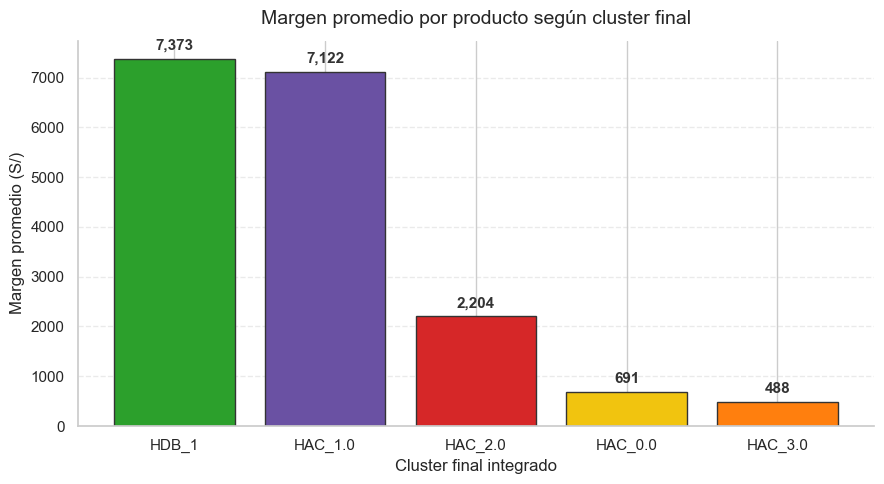

In [314]:
import matplotlib.pyplot as plt
import numpy as np

# Paleta definida
palette_clusters = {
    "HDB_1": "#2ca02c",   # verde CORE
    "HAC_1.0": "#6a51a3", # morado
    "HAC_2.0": "#d62728", # rojo
    "HAC_0.0": "#f1c40f", # amarillo
    "HAC_3.0": "#ff7f0e", # naranja
}

df_bar = resumen.sort_values("margen_promedio", ascending=False).copy()

fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.bar(
    df_bar["cluster_final_id"],
    df_bar["margen_promedio"],
    color=[palette_clusters[c] for c in df_bar["cluster_final_id"]],
    edgecolor="#333333",
    linewidth=1.0,
)

# Etiquetas arriba de cada barra
for bar, value in zip(bars, df_bar["margen_promedio"]):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 120,
        f"{value:,.0f}",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold',
        color="#333333"
    )

# Títulos y ejes
ax.set_title("Margen promedio por producto según cluster final", fontsize=14, pad=12)
ax.set_ylabel("Margen promedio (S/)", fontsize=12)
ax.set_xlabel("Cluster final integrado", fontsize=12)

# Estética
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 5.4 Clusters finales integrados y análisis estratégico del portafolio

La combinación del modelo HDBSCAN y el refinamiento mediante clusterización jerárquica con cortes dinámicos, guiado por el índice IPIP y el margen total, permite obtener una segmentación final más precisa que refleja no solo desempeño económico, sino también eficiencia operativa real basada en estructura de insumos. Este enfoque supera la visión estrictamente heurística de la Ingeniería del Menú tradicional, revelando diferencias estructurales que no son visibles únicamente desde el margen o la frecuencia de venta.

Los resultados finales se presentan en la Tabla 8.

### Tabla 8. Resumen de clusters finales del portafolio

| modelo_origen | cluster_final_id | n_items | margen_total | share_margen (%) | avg_q_insumos | avg_pop_mean | margen_promedio |
|---------------|------------------|---------|--------------|------------------|---------------|--------------|-----------------|
| HDBSCAN       | HDB_1            | 23      | 169,587.04   | 85.52            | 8.13          | 0.330        | 7,373.35        |
| JERARQUICO    | HAC_2.0          | 4       | 8,816.86     | 4.45             | 14.75         | 0.111        | 2,204.21        |
| JERARQUICO    | HAC_1.0          | 1       | 7,121.78     | 3.59             | 21.00         | 0.104        | 7,121.78        |
| JERARQUICO    | HAC_0.0          | 10      | 6,908.09     | 3.48             | 9.00          | 0.349        | 690.81          |
| JERARQUICO    | HAC_3.0          | 12      | 5,857.73     | 2.95             | 15.25         | 0.188        | 488.14          |

### Interpretación estratégica de los clusters finales

- HDB_1: Grupo CORE del negocio. Reúne 23 platos responsables del 85.52% del margen total, con baja complejidad operativa (8 insumos promedio) y alto índice de aprovechamiento de insumos. Su margen promedio elevado (S/ 7,373.35) confirma su relevancia estratégica. Deben mantenerse y potenciarse como base estable del portafolio.

- HAC_1.0: Producto diferenciador de alto margen unitario, pero con la mayor complejidad operativa del portafolio (21 insumos). Recomendación: evaluar rediseño de receta o sustitución de insumos para reducir costos sin comprometer su contribución.

- HAC_2.0: Productos de valor medio y complejidad alta. Candidatos a simplificación operativa, control de costos o reposicionamiento comercial.

- HAC_0.0: Volumen bajo y margen ajustado (S/ 690.81 en promedio). Candidatos a eliminación gradual o sustitución por alternativas más eficientes.

- HAC_3.0: Bajo rendimiento económico y operativo. Recomendación principal: depuración inmediata o rediseño radical.

En conjunto, la estructura final presenta una priorización clara: mantener e impulsar el grupo CORE (HDB_1), optimizar productos diferenciadores, y depurar los grupos de bajo rendimiento. La integración de HDBSCAN + Jerárquico + IPIP habilita una gestión del portafolio basada en datos, superando la toma de decisiones intuitiva tradicional y maximizando la eficiencia económica y operativa del menú.

## 6. Discusión

El uso de heurísticas tradicionales como la **Matriz de Ingeniería del Menú** ha sido históricamente la principal herramienta para la toma de decisiones en la gestión de portafolios gastronómicos. Esta matriz clasifica los productos según dos variables visibles —frecuencia de venta y margen unitario— permitiendo identificar grupos como *populares, estrellas, apoyo o interrogantes*. Sin embargo, en portafolios operativamente complejos, esta aproximación puede volverse insuficiente, ya que simplifica excesivamente la realidad y deja zonas grises donde la decisión final no es evidente.

En la Figura 18 se observa esta situación: muchos productos se ubican en zonas ambiguas y fronterizas donde no queda claro si deben mantenerse, rediseñarse o eliminarse. La interpretación visual aislada puede conducir a decisiones reactivas y subjetivas, sin considerar otros factores relevantes como la complejidad operativa o la estructura de insumos.

In [315]:
cluster_palette = {
    "HDB_1": "#2ca02c",   # verde
    "HAC_1.0": "#6a51a3", # rojo
    "HAC_2.0": "#d62728", # naranja
    "HAC_0.0": "#f1c40f", # amarillo
    "HAC_3.0": "#d62728"  # morado (por si quieres dejar uno igual)
}

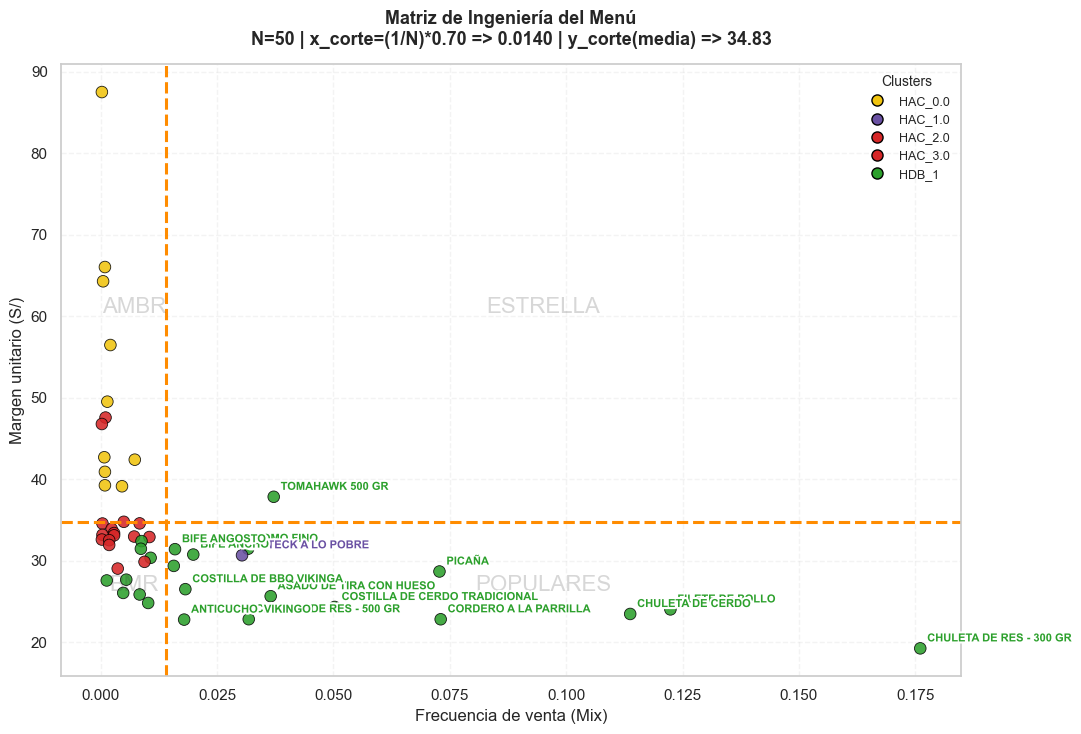

(<Figure size 1100x750 with 1 Axes>,
 <Axes: title={'center': 'Matriz de Ingeniería del Menú\nN=50 | x_corte=(1/N)*0.70 => 0.0140 | y_corte(media) => 34.83'}, xlabel='Frecuencia de venta (Mix)', ylabel='Margen unitario (S/)'>)

In [316]:
an = MenuEngineeringAnalyzer(
    col_nombre="item_nombre",
    col_units="unidades_totales",
    col_margen="margen",
    col_categoria="categoria",
    col_cluster="cluster_final_id",
    popularity_factor=0.70,
    margin_method="mean",
    quadrant_labels=("ESTRELLA", "POPULARES", "AMBR", "BMR"),
)
an.fit(df)
an.plot( size_transform="none", label_mode="topk",
        cluster_palette=cluster_palette)

La primera segmentación mediante HDBSCAN permitió identificar **patrones naturales sin imponer el número de grupos**, revelando con claridad un **grupo CORE altamente estable**, responsable del **85% del margen total** y con baja complejidad operativa (8 insumos promedio). Sin embargo, los grupos restantes mostraron heterogeneidad interna: coexistían productos con margen bajo pero insumos compartidos y productos con buenos márgenes pero extremadamente costosos de operar debido a baja popularidad o insumos exclusivos.

Esto evidencia que decisiones simples como *“este producto tiene bajo margen, retíralo”* pueden ser equivocadas. Por ejemplo, el subcluster identificado como **HAC_1.0**, que representa solo el **5% del margen**, fue aislado naturalmente por el clustering jerárquico debido a su **altísima complejidad operativa (21 insumos)** y baja popularidad. Detectar este tipo de casos manualmente hubiese sido prácticamente imposible desde la matriz tradicional.

La combinación de clustering jerárquico con **corte dinámico basado en el índice IPIP** permitió desambiguar estos grupos difusos y refinar la segmentación final, revelando con claridad:
- qué productos deben **mantenerse e impulsarse** (HDB_1),
- cuáles deben **optimizarse o rediseñarse** (HAC_2.0 y HAC_3.0),
- y cuáles son **candidatos directos a eliminación estratégica** (HAC_1.0).

## **Conclusiones**

Los resultados obtenidos evidencian que las herramientas heurísticas tradicionales —como la Ingeniería del Menú en gastronomía, la Matriz BCG en estrategia corporativa o la matriz de McKinsey para análisis de portafolio—, si bien aportan simplicidad y una base visual para la toma de decisiones, pueden conducir a conclusiones imprecisas cuando se aplican en contextos operativos complejos. Estas metodologías bidimensionales solo consideran una fracción de la información disponible y pueden resultar insuficientes para capturar interacciones estructurales, como la complejidad operativa o las dependencias en la cadena de suministro.

Este estudio demuestra que **decisiones basadas únicamente en heurística pueden ser equivocadas**: productos que parecen candidatos a eliminación por bajo margen pueden, en realidad, ser altamente eficientes gracias al uso intensivo de insumos compartidos; mientras que otros productos aparentemente rentables pueden ser extremadamente costosos de sostener operativamente cuando dependen de insumos exclusivos y poco frecuentes.

La integración de enfoques basados en **Machine Learning y análisis multivariable**, como HDBSCAN y clustering jerárquico con cortes dinámicos guiados por métricas operativas, permite revelar **patrones naturales no observables a simple vista**, habilitando segmentaciones más precisas y estructuradas.

Más que reemplazar a la heurística empresarial, se propone **utilizarla como complemento** dentro de un proceso de toma de decisiones robusto, donde los datos y el aprendizaje automático actúan como un filtro analítico adicional que mejora la calidad final del criterio ejecutivo.

Este enfoque abre la puerta a una nueva etapa en la gestión de portafolios y en la toma estratégica de decisiones, en la que las organizaciones pueden:
- reducir complejidad y costos sin sacrificar valor,
- asignar recursos con precisión quirúrgica,
- acelerar innovación basada en evidencia,
- y construir ventajas competitivas sostenibles basadas en datos.

En síntesis, **la combinación de heurística + analítica avanzada representa un modelo superior**, donde las decisiones dejan de ser reactivas y se convierten en decisiones inteligentes, sustentadas y estratégicamente alineadas con los objetivos de largo plazo.